In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from olympus.datasets import Dataset
from olympus.objects import (
    ParameterContinuous,
    ParameterDiscrete, 
    ParameterCategorical, 
    ParameterVector
)
from olympus.campaigns import ParameterSpace, Campaign

from atlas.planners.multi_fidelity.planner import MultiFidelityPlanner
from atlas.planners.gp.planner import GPPlanner

In [13]:
# set the low and high-fidelity functions
def measure_high(x):
    return np.sin(25*x) * np.exp(-0.4*np.pi*x)

def measure_low(x):
    return np.sin(25*x) * np.exp(-0.7*np.pi*x) + 0.5

def compute_cost(observations):
    return np.sum(observations.get_params()[:, 0].astype(float))


In [14]:
# minimum of high fidelity function
measure_high(-0.128243 + 0.483322*1.)

0.3333475049109851

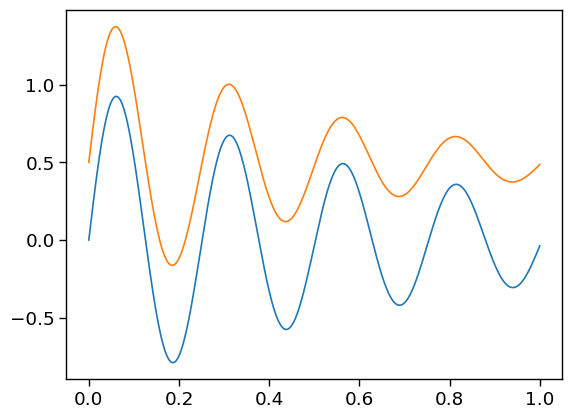

In [15]:
domain = np.linspace(0., 1., 1000)
plt.plot(domain, measure_high(domain), label='high fidelity')
plt.plot(domain, measure_low(domain), label='low fidelity')

In [16]:
# set up the problem with atlas
param_space = ParameterSpace()
param_space.add(ParameterDiscrete(name='s', options=[0.1, 1.]))
param_space.add(ParameterContinuous(name='x0', low=0., high=1.))



In [ ]:
# multi-fidelity planner
BUDGET = 10
NUM_RUNS = 10

all_data = []
for run_ix in range(NUM_RUNS):
    
    planner = MultiFidelityPlanner(
        goal='minimize',
        fidelity_params=0,
        fidelities=[0.1, 1.],
        acquisition_optimizer_kind='pymoo',
    )
    planner.set_param_space(param_space)
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    target_rec_measurements = []
    
    cumul_cost = []
    max_cumul_cost = 0.
    iter_ = 0
    while max_cumul_cost < BUDGET: 
    #while campaign.num_obs < BUDGET:
        print('='*50)
        print('='*50)
        print('ITER : ', iter_)
        print('CUMUL COST PRE : ', cumul_cost)
        if iter_ % 4 == 0:
            planner.set_ask_fidelity(1.0)
        else:
            planner.set_ask_fidelity(0.1)
        print('CURRENT ASK FIDELITY : ', planner.current_ask_fidelity)
        samples = planner.recommend(campaign.observations)
        for sample in samples:
            s = sample.s
            if s==1.:
                measurement = measure_high(sample.x0)
            elif s==0.1:
                measurement = measure_low(sample.x0)
            campaign.add_observation(sample, measurement)
            cumul_cost.append( compute_cost(campaign.observations) )
            max_cumul_cost = np.amax(cumul_cost)
            
            print('SAMPLE : ', sample)
            print('MEASUREMENT : ', measurement)
            print('CUMUL COST POST : ', cumul_cost)
            
            iter_ += 1
            
            if campaign.num_obs >= 5+1:
                # make a prediction on the target fidelity and measure greedy
                rec_sample = planner.recommend_target_fidelity(batch_size=1)[0]
                rec_measurement = measure_high(rec_sample.x0)
                target_rec_measurements.append(rec_measurement)
                
            else:
                # just record the current measurement
                target_rec_measurements.append(measurement)
            
            
    # store results in dataframe
    s_col = campaign.observations.get_params()[:, 0]
    x0_col = campaign.observations.get_params()[:, 1]

    obj0 = np.array(target_rec_measurements) #campaign.observations.get_values()
    
#     high_fidelity_obj0 = []
#     high_fi_meas = obj0[0]
#     for s, meas in zip(s_col, obj0):
#         if s==1.:
#             high_fi_meas = meas
#         else:
#             pass
#         print(s, meas, high_fi_meas)
#         high_fidelity_obj0.append(high_fi_meas)

    data = pd.DataFrame({
        'cumul_cost': np.array(cumul_cost),
        's': s_col,
        'x0': x0_col,
        'obj': target_rec_measurements,
    })
    all_data.append(data)
    pickle.dump(all_data, open('mf_results.pkl', 'wb'))
        

In [ ]:
# VANILLA GPPlanner
BUDGET = 10
NUM_RUNS = 10

param_space_ = ParameterSpace()
param_space_.add(ParameterContinuous(name='x0', low=0., high=1.))

all_data = []
for run_ix in range(NUM_RUNS):
    
    planner = GPPlanner(goal='minimize')
    planner.set_param_space(param_space_)
    
    campaign = Campaign()
    campaign.set_param_space(param_space_)
    
    cumul_cost = []
    while campaign.num_obs < BUDGET:
        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = measure_high(sample.x0)
            campaign.add_observation(sample, measurement)
            cumul_cost.append(campaign.num_obs)
            
    # store results in dataframe
    s_col = np.ones(len(campaign.observations.get_values()))
    x0_col = campaign.observations.get_params()[:, 0]

    obj0_col = campaign.observations.get_values()

    data = pd.DataFrame({
        'cumul_cost': np.array(cumul_cost),
        's': s_col,
        'x0': x0_col,
        'obj': obj0_col,
    })
    all_data.append(data)
    pickle.dump(all_data, open('bo_results.pkl', 'wb'))

## Plot and analyze results

In [2]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(np.array(trace_min))
    return np.array(traces_min)

# def get_traces_min_for_categorical(data, replace_nan=True):
#     traces_min = []
#     for df in data:
#         trace = np.zeros(100)  # up to 100
#         results = df.loc[:, 'obj'].to_numpy()[:100]  # up to 100
#         trace[:len(results)] = results
        
#         # if first is nan, replace with first non-nan
#         if replace_nan is True:
#             if np.isnan(trace[0]):
#                 for val in trace[1:]:
#                     if not np.isnan(val):
#                         trace[0] = val
#                         break
#         trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
#         traces_min.append(trace_min)
#     return np.array(traces_min)

def plot_min_trace_mean(
    data, ax=None, color=None, label=None, categorical=False, stde=False, unc=True, shift=0.0, maximize=False,
    linewidth=4, 
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min(data)-shift #get_traces_min_for_categorical(data) - shift
        else:
        
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
    
    mean = np.nanmean(traces_min, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_min, axis=0, ddof=1)
        
    #x = range(1, np.shape(traces_min)[1]+1, 1)
    # cumulative cost instead of number evals
    x = data[0]['cumul_cost'].values
    

    ax.plot(x, mean, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, mean, color=color, linewidth=linewidth, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    return plot_
        

In [ ]:
res_mf = pickle.load(open('mf_results.pkl', 'rb'))
res_bo = pickle.load(open('bo_results.pkl', 'rb'))
len(res_mf), len(res_bo)

In [ ]:
#res_mf[1]

In [ ]:
fig, ax = plt.subplots()
#for res in res_mf:
#    plot_min_trace_mean([res], unc=False,linewidth=1, color='#92a4de', shift=-0.637082925950332, ax=ax)
plot_min_trace_mean(res_mf, stde=True, color='#92a4de',  label='MultiFidelityPlanner', ax=ax)
plot_min_trace_mean(res_bo, stde=True, color='#a1498e',  label='GPPlanner', ax=ax)
ax.legend(loc='upper right')

# ax.set_yscale('log')


## Higher-dimensional continuous/categorical examples 

In [ ]:
from olympus.surfaces import Surface

SURFACE_KIND = 'CatMichalewicz'
DIM = 2

surface = Surface(kind=SURFACE_KIND)

In [ ]:
def measure(params, s):
    x0 = params.param_0
    x1 = params.param_1
    if s == 1.:
        measurement = surface.run([x0, x1])[0][0] # high fidelity
    if s == 0.1:
        print(surface.run([x0, x1]))
        measurement = surface.run([x0, x1])[0][0] + 0.5 # low fidelity
    return measurement



In [ ]:
BUDGET = 20
NUM_RUNS = 15


param_space = ParameterSpace()
param_space.add(ParameterDiscrete(name='s', options=[0.1, 1.]))
for param in surface.param_space:
    param.descriptors = [[float(i)] for i in range(21)]
    param_space.add(param)
    
    
print(param_space.param_names)
print(param_space)

all_data = []
for run_ix in range(NUM_RUNS):
    
    planner = MultiFidelityPlanner(
        goal='minimize',
        use_descriptors=True, # TODO: play around with this
        fidelity_params=0,
        fidelities=[0.1, 1.],
        acquisition_optimizer_kind='pymoo',
    )
    planner.set_param_space(param_space)
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    target_rec_measurements = []
    
    cumul_cost = []
    max_cumul_cost = 0.
    iter_ = 0
    while max_cumul_cost < BUDGET: 
    #while campaign.num_obs < BUDGET:
        print('='*50)
        print('='*50)
        print('ITER : ', iter_)
        print('CUMUL COST PRE : ', cumul_cost)
        if iter_ % 4 == 0:
            planner.set_ask_fidelity(1.0)
        else:
            planner.set_ask_fidelity(0.1)
        print('CURRENT ASK FIDELITY : ', planner.current_ask_fidelity)
        samples = planner.recommend(campaign.observations)
        for sample in samples:
#             s = sample.s
#             if s==1.:
#                 measurement = measure_high(sample)
#             elif s==0.1:
#                 measurement = measure_low(sample)
            measurement = measure(sample, sample.s)
            campaign.add_observation(sample, measurement)
            cumul_cost.append( compute_cost(campaign.observations) )
            max_cumul_cost = np.amax(cumul_cost)
            
            print('SAMPLE : ', sample)
            print('MEASUREMENT : ', measurement)
            print('CUMUL COST POST : ', cumul_cost)
            
            iter_ += 1
            
            if campaign.num_obs >= 5+1:
                # make a prediction on the target fidelity and measure greedy
                rec_sample = planner.recommend_target_fidelity(batch_size=1)[0]
                rec_measurement = measure(rec_sample, s=1.0)
                target_rec_measurements.append(rec_measurement)
                
            else:
                # just record the current measurement
                target_rec_measurements.append(measurement)
            
            
    # store results in dataframe
    s_col = campaign.observations.get_params()[:, 0]
    x0_col = campaign.observations.get_params()[:, 1]
    x1_col = campaign.observations.get_params()[:, 2]

    obj0 = np.array(target_rec_measurements) #campaign.observations.get_values()

    data = pd.DataFrame({
        'cumul_cost': np.array(cumul_cost),
        's': s_col,
        'x0': x0_col,
        'x1': x1_col,
        'obj': target_rec_measurements,
    })
    all_data.append(data)
    pickle.dump(all_data, open('mf_cat_results.pkl', 'wb'))

In [ ]:
# VANILLA GPPlanner CAT
BUDGET = 30
NUM_RUNS = 50

param_space = surface.param_space
param_space_ = ParameterSpace()
for param in param_space:
    param.descriptors = [[float(i)] for i in range(21)]
    param_space_.add(param)

print(param_space_)
    
all_data = []
for run_ix in range(NUM_RUNS):
    
    planner = GPPlanner(goal='minimize', use_descriptors=True)
    planner.set_param_space(param_space_)
    
    campaign = Campaign()
    campaign.set_param_space(param_space_)
    
    cumul_cost = []
    while campaign.num_obs < BUDGET:
        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = measure(sample, s=1.0)
            campaign.add_observation(sample, measurement)
            cumul_cost.append(campaign.num_obs)
            
    # store results in dataframe
    s_col = np.ones(len(campaign.observations.get_values()))
    x0_col = campaign.observations.get_params()[:, 0]
    x1_col = campaign.observations.get_params()[:, 1]

    obj0_col = campaign.observations.get_values()

    data = pd.DataFrame({
        'cumul_cost': np.array(cumul_cost),
        's': s_col,
        'x0': x0_col,
        'x1': x1_col,
        'obj': obj0_col,
    })
    all_data.append(data)
    pickle.dump(all_data, open('bo_cat_results.pkl', 'wb'))

In [3]:
res_mf = pickle.load(open('mf_cat_results.pkl', 'rb'))
res_bo = pickle.load(open('bo_cat_results.pkl', 'rb'))
len(res_mf), len(res_bo)

(15, 29)

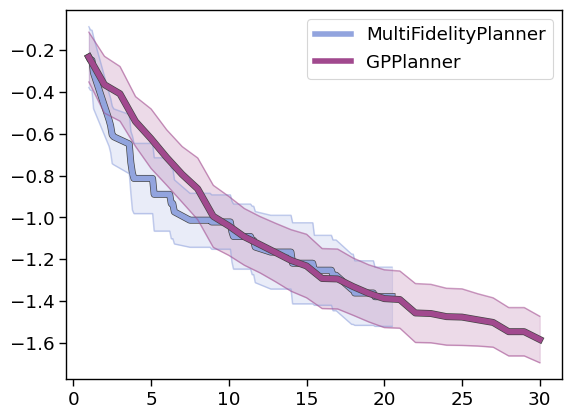

In [4]:
fig, ax = plt.subplots()
#for res in res_mf:
#    plot_min_trace_mean([res], unc=False,linewidth=1, color='#92a4de', shift=-0.637082925950332, ax=ax)
plot_min_trace_mean(res_mf, stde=True, color='#92a4de',  label='MultiFidelityPlanner', ax=ax)
plot_min_trace_mean(res_bo, stde=True, color='#a1498e',  label='GPPlanner', ax=ax)
ax.legend(loc='upper right')

In [ ]:
surface.minima

## High-dimensional continuous functions

In [26]:
from olympus.surfaces import Surface

SURFACE_KIND = 'Schwefel'
DIM = 6

surface = Surface(kind=SURFACE_KIND, param_dim=DIM)

def measure(params, s):
    x0 = params.param_0
    x1 = params.param_1
    x2 = params.param_2
    x3 = params.param_3
    x4 = params.param_4
    x5 = params.param_5
    if s == 1.:
        measurement = surface.run([x0,x1,x2,x3,x4,x5])[0][0] # high fidelity
    if s == 0.1:
        measurement = surface.run([x0,x1,x2,x3,x4,x5])[0][0] + 0.5 # low fidelity
    return measurement


In [27]:
BUDGET = 20
NUM_RUNS = 10


param_space = ParameterSpace()
param_space.add(ParameterDiscrete(name='s', options=[0.1, 1.]))
for param in surface.param_space:
    param_space.add(param)
    
print(param_space)


all_data = []
for run_ix in range(NUM_RUNS):
    
    planner = MultiFidelityPlanner(
        goal='minimize',
        use_descriptors=True, # TODO: play around with this
        fidelity_params=0,
        fidelities=[0.1, 1.],
        acquisition_optimizer_kind='pymoo',
    )
    planner.set_param_space(param_space)
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    target_rec_measurements = []
    
    cumul_cost = []
    max_cumul_cost = 0.
    iter_ = 0
    while max_cumul_cost < BUDGET: 
    #while campaign.num_obs < BUDGET:
        print('='*50)
        print('='*50)
        print('ITER : ', iter_)
        print('CUMUL COST PRE : ', cumul_cost)
        if iter_ % 4 == 0:
            planner.set_ask_fidelity(1.0)
        else:
            planner.set_ask_fidelity(0.1)
        print('CURRENT ASK FIDELITY : ', planner.current_ask_fidelity)
        samples = planner.recommend(campaign.observations)
        for sample in samples:
#             s = sample.s
#             if s==1.:
#                 measurement = measure_high(sample)
#             elif s==0.1:
#                 measurement = measure_low(sample)
            measurement = measure(sample, sample.s)
            campaign.add_observation(sample, measurement)
            cumul_cost.append( compute_cost(campaign.observations) )
            max_cumul_cost = np.amax(cumul_cost)
            
            print('SAMPLE : ', sample)
            print('MEASUREMENT : ', measurement)
            print('CUMUL COST POST : ', cumul_cost)
            
            iter_ += 1
            
            if campaign.num_obs >= 5+1:
                # make a prediction on the target fidelity and measure greedy
                rec_sample = planner.recommend_target_fidelity(batch_size=1)[0]
                rec_measurement = measure(rec_sample, s=1.0)
                target_rec_measurements.append(rec_measurement)
                
            else:
                # just record the current measurement
                target_rec_measurements.append(measurement)
            
            
    # store results in dataframe
    s_col = campaign.observations.get_params()[:, 0]
    x0_col = campaign.observations.get_params()[:, 1]
    x1_col = campaign.observations.get_params()[:, 2]
    x2_col = campaign.observations.get_params()[:, 3]
    x3_col = campaign.observations.get_params()[:, 4]
    x4_col = campaign.observations.get_params()[:, 5]
    x5_col = campaign.observations.get_params()[:, 6]

    obj0 = np.array(target_rec_measurements) #campaign.observations.get_values()

    data = pd.DataFrame({
        'cumul_cost': np.array(cumul_cost),
        's': s_col,
        'x0': x0_col,
        'x2': x2_col,
        'x3': x3_col,
        'x4': x4_col,
        'x5': x5_col,
        'obj': target_rec_measurements,
    })
    all_data.append(data)
    pickle.dump(all_data, open('mf_cont_high_results.pkl', 'wb'))

Discrete (name='s', low=0.1, high=1.0, stride=0.1, options=[0.1, 1.0])
Continuous (name='param_0', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_1', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_2', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_3', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_4', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_5', low=0.0, high=1.0, is_periodic=False)


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.920529546080617, param_1 = 0.06478148271065798, param_2 = 0.15841126225647262, param_3 = 0.05881456135935792, param_4 = 0.8444672008361288, param_5 = 0.39252083337003285)
MEASUREMENT :  231.32475246575467
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.863517604828909, param_1 = 0.855452512735744, param_2 = 0.7864368993642726, param_3 = 0.5677720264765208, param_4 = 0.27437546439980587, param_5 = 0.028941266636344998)
MEASUREMENT :  403.2534799990693
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8724420609383934, param_1 = 0.7936917997461989, param_2 = 0.45028812907812243, param_3 = 0.1545800494929842, param_4 = 0.7153136500265678, param_5 = 0.8462114878758829)
MEASUREMENT :  -27.951256708732316
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.27484234916732964, param_1 = 0.13713823135211844, param_2 = 0.6924766419635471, param_3 = 0.35349856380301303, param_4 = 0.31676938978627467, param_5 = 0.21051664795811686)
MEASUREMENT :  -161.60343595367607
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.12904341680080744, param_1 = 0.9594285940876209, param_2 = 0.7699026300632466, param_3 = 0.7760697320821133, param_4 = 0.29801170236750263, param_5 = 0.9393639400531703)
MEASUREMENT :  125.63452492538988
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7324802050811197, param_1 = 0.7867326166228571, param_2 = 0.5202158835669264, param_3 = 0.15937423093048764, param_4 = 0.17823122466462638, param_5 = 0.5304180020405505)
MEASUREMENT :  -177.1581778717776
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.724254016943291, param_1 = 0.4940846055257405, param_2 = 0.32183809766772964, param_3 = 0.0011752984156848667, param_4 = 0.6537124720788892, param_5 = 0.665896786283667)
MEASUREMENT :  -213.52303243576102
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.267108956062012, param_1 = 0.9085647762692578, param_2 = 0.7896309472329937, param_3 = 0.7568502909539228, param_4 = 0.8636587689282218, param_5 = 0.6222215608563385)
MEASUREMENT :  104.27284531330223
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.06268941832383279, param_1 = 0.9749953791684113, param_2 = 0.3742627046084732, param_3 = 0.6219175209363108, param_4 = 0.8307402089236328, param_5 = 0.21274308848497248)
MEASUREMENT :  223.57379148858428
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8356696021369616, param_1 = 0.35315126557142373, param_2 = 0.40390947307435776, param_3 = 0.01531511114143258, param_4 = 0.05305126578190289, param_5 = 0.5202358024223341)
MEASUREMENT :  414.3249027465348
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7836261148652376, param_1 = 0.6148775165997714, param_2 = 0.577843657635908, param_3 = 0.8095013838946387, param_4 = 0.6699951376743833, param_5 = 0.9382310521523665)
MEASUREMENT :  159.23776897920425
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4555387811742172, param_1 = 0.943321688046396, param_2 = 0.8283941559349739, param_3 = 0.7878800685069556, param_4 = 0.7686525159052481, param_5 = 0.7061301983429902)
MEASUREMENT :  121.05463792351227
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.44573846693640895, param_1 = 0.8505323179154923, param_2 = 0.9981971729662815, param_3 = 0.9491831807130648, param_4 = 0.48360487256300755, param_5 = 0.24090146536231705)
MEASUREMENT :  -179.03136478796222
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.16616562957128667, param_1 = 0.34056168627444594, param_2 = 0.9225310293646604, param_3 = 0.34236762550020805, param_4 = 0.7637645428483193, param_5 = 0.8084818735345256)
MEASUREMENT :  -162.76383318954043
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4000256318974176, param_1 = 0.879441818638807, param_2 = 0.7523093490212012, param_3 = 0.7833520197030083, param_4 = 0.44012822162347043, param_5 = 0.771400087932301)
MEASUREMENT :  270.3507963988927
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3428392478539347, param_1 = 0.8827383345855607, param_2 = 0.3455476283625608, param_3 = 0.8607242687478557, param_4 = 0.8034914446044725, param_5 = 0.7862737629898804)
MEASUREMENT :  240.74543699845174
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.06886991066878811, param_1 = 0.7920082929118648, param_2 = 0.4898933488207222, param_3 = 0.18713284089188176, param_4 = 0.025347520443425253, param_5 = 0.4355633661603263)
MEASUREMENT :  565.2140091297754
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.19236584261887013, param_1 = 0.6166871232044361, param_2 = 0.9527515933934959, param_3 = 0.25253667933031865, param_4 = 0.8465111094519533, param_5 = 0.4224148755911754)
MEASUREMENT :  -358.669804497113
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.43335546505247635, param_1 = 0.6359798883774316, param_2 = 0.0840317233793112, param_3 = 0.36277977333956135, param_4 = 0.6966742701688738, param_5 = 0.9065820813211797)
MEASUREMENT :  -105.21790581635071
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5454964223041412, param_1 = 0.5104220571118203, param_2 = 0.12874993886786257, param_3 = 0.292631033418957, param_4 = 0.7252876931652242, param_5 = 0.4721615442403597)
MEASUREMENT :  163.77605787988213
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5922225450171015, param_1 = 0.49134027483901943, param_2 = 0.6861002954042879, param_3 = 0.04813085223829694, param_4 = 0.4920558554917077, param_5 = 0.24898574840277754)
MEASUREMENT :  125.63041367301315
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.09099762217866303, param_1 = 0.6052077447988325, param_2 = 0.1913617884090606, param_3 = 0.4797183364464984, param_4 = 0.491628411949961, param_5 = 0.164785105908978)
MEASUREMENT :  -6.707163989153713
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5862356217405469, param_1 = 0.3221161154999065, param_2 = 0.3974464574886616, param_3 = 0.6883712180473788, param_4 = 0.12620326905817325, param_5 = 0.26320482559957603)
MEASUREMENT :  122.20474248028796
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5846456428954903, param_1 = 0.602592897535498, param_2 = 0.07773252845503764, param_3 = 0.25710641487204144, param_4 = 0.3213023027481329, param_5 = 0.3322085363020383)
MEASUREMENT :  688.320656862809
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8249470457603055, param_1 = 0.5519664790302158, param_2 = 0.10048121740581673, param_3 = 0.29741617814193255, param_4 = 0.28126411905374105, param_5 = 0.4269651303530031)
MEASUREMENT :  991.2129532295468
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1038215950711433, param_1 = 0.10029160217566468, param_2 = 0.1886400721400876, param_3 = 0.2981236119431181, param_4 = 0.2744399905841979, param_5 = 0.9312998557008708)
MEASUREMENT :  357.40746838015434
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.118 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2956291150637528, param_1 = 0.14489534449395491, param_2 = 0.17957251292604925, param_3 = 0.6369544795340988, param_4 = 0.09467242091167871, param_5 = 0.08339795163385466)
MEASUREMENT :  849.3172342614002
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.074 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2901392267014016, param_1 = 0.8077841356443448, param_2 = 0.2522817939888593, param_3 = 0.4684908831838174, param_4 = 0.8482633979412012, param_5 = 0.6516461410926618)
MEASUREMENT :  570.2480575755519
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7303294469142971, param_1 = 0.77729325717164, param_2 = 0.7877367567762398, param_3 = 0.4947246015404013, param_4 = 0.6275442986021418, param_5 = 0.3743966124231446)
MEASUREMENT :  384.46449196023605
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9839768383422104, param_1 = 0.3048232614852959, param_2 = 0.4583018505131019, param_3 = 0.8030632377876228, param_4 = 0.25615811737172667, param_5 = 0.6676679122221388)
MEASUREMENT :  464.72051007328633
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7464598251033103, param_1 = 0.29732922748861945, param_2 = 0.6123395915411917, param_3 = 0.47779827287765597, param_4 = 0.9272116784627189, param_5 = 0.6692062483953795)
MEASUREMENT :  -204.97498345760368
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.073 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6627734942982264, param_1 = 0.18162233612791068, param_2 = 0.7933002626849773, param_3 = 0.867977077326849, param_4 = 0.635706702006879, param_5 = 0.7043768460288575)
MEASUREMENT :  -224.08518523822428
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.021577936916847174, param_1 = 0.48132835205915936, param_2 = 0.3171855170224288, param_3 = 0.5489951890995409, param_4 = 0.2464117393089389, param_5 = 0.42914582255850386)
MEASUREMENT :  161.63312390643847
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5705628563678911, param_1 = 0.134685059934897, param_2 = 0.9458586089025742, param_3 = 0.062327144174196714, param_4 = 0.7160997009185948, param_5 = 0.2312424192010042)
MEASUREMENT :  -275.9383180342857
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4008626802581641, param_1 = 0.9805633039167598, param_2 = 0.4489216425128185, param_3 = 0.8662131541577338, param_4 = 0.8530180245813579, param_5 = 0.7331217353523212)
MEASUREMENT :  -225.76731844197917
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.004536002065636757, param_1 = 0.8569298186091145, param_2 = 0.8768069093184008, param_3 = 0.6605465589332349, param_4 = 0.4969810212268344, param_5 = 0.26398915655100164)
MEASUREMENT :  -280.62596683721335
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.49293006811988604, param_1 = 0.7031668669141885, param_2 = 0.12494911009039944, param_3 = 0.9204827596960585, param_4 = 0.33566512144883087, param_5 = 0.05411611737199651)
MEASUREMENT :  -48.775121103144954
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5361604253545121, param_1 = 0.5424793435425693, param_2 = 0.8026142209909131, param_3 = 0.9061782780813602, param_4 = 0.30309227966274166, param_5 = 0.902900448827523)
MEASUREMENT :  -273.9511631169443
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.06474191374986737, param_1 = 0.9204839496150088, param_2 = 0.9809127041148706, param_3 = 0.4397094580414136, param_4 = 0.10283211146376237, param_5 = 0.5242300965642943)
MEASUREMENT :  379.3052354117883
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.077 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8061163706272245, param_1 = 0.7488985669891915, param_2 = 0.5104666992723992, param_3 = 0.6528619473095205, param_4 = 0.38079636552493124, param_5 = 0.5360311251554374)
MEASUREMENT :  239.33429336786946
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.077 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7176734383485417, param_1 = 0.9113659798556403, param_2 = 0.08392026745897718, param_3 = 0.4517013285952892, param_4 = 0.27597519631784173, param_5 = 0.31007795425006257)
MEASUREMENT :  189.96185800439255
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9571730363093378, param_1 = 0.3870896942220532, param_2 = 0.8584056628275327, param_3 = 0.1399849128612065, param_4 = 0.9313571454174022, param_5 = 0.27106040985740876)
MEASUREMENT :  -631.6310961029669
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.081 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4867405984908969, param_1 = 0.9759130319284687, param_2 = 0.4727259408251775, param_3 = 0.6984048289003586, param_4 = 0.26857296528287256, param_5 = 0.9432977507988951)
MEASUREMENT :  -558.0852450022448
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.085 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3318228067987624, param_1 = 0.8273087410490689, param_2 = 0.29786763715450915, param_3 = 0.16720310022109086, param_4 = 0.5938967192625145, param_5 = 0.23113622715593285)
MEASUREMENT :  156.63797859970617
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6572574079633025, param_1 = 0.04072610262674914, param_2 = 0.2329412011583316, param_3 = 0.254839232831768, param_4 = 0.7797510792112996, param_5 = 0.15470121457615915)
MEASUREMENT :  249.24009900045104
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.088 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.25011468308437335, param_1 = 0.8190622905946057, param_2 = 0.061484280429111804, param_3 = 0.8833540234895811, param_4 = 0.10151193237772393, param_5 = 0.495934872206249)
MEASUREMENT :  727.7698454561154
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6204547848910774, param_1 = 0.9560035492983829, param_2 = 0.5724709789874375, param_3 = 0.3198928757861468, param_4 = 0.3772268755401469, param_5 = 0.17503408753458272)
MEASUREMENT :  -432.30626910905846
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.09537579223870007, param_1 = 0.4091320966679085, param_2 = 0.6657608978888397, param_3 = 0.9369734072326571, param_4 = 0.08848791901991437, param_5 = 0.4174165607821788)
MEASUREMENT :  374.5945963885068
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.115 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.18252557178413087, param_1 = 0.8525046374280733, param_2 = 0.2414648088200172, param_3 = 0.6475854687676358, param_4 = 0.05164009914347556, param_5 = 0.005129235940734556)
MEASUREMENT :  -77.91078330500578
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5943022483732326, param_1 = 0.889542412001651, param_2 = 0.3038228714777377, param_3 = 0.718136957623758, param_4 = 0.27319744497725296, param_5 = 0.6659879277582693)
MEASUREMENT :  -171.2656149139676
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.11 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9668197595379595, param_1 = 0.5798868637066384, param_2 = 0.7163175478533488, param_3 = 0.4338137741574887, param_4 = 0.8400966697152067, param_5 = 0.9202763068375035)
MEASUREMENT :  -614.7501247292772
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.112 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5717505405546355, param_1 = 0.4774202390774639, param_2 = 0.09736066830430734, param_3 = 0.6894153618171727, param_4 = 0.816914020220262, param_5 = 0.9656962639878087)
MEASUREMENT :  209.08517977943845
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3274020849640804, param_1 = 0.9673328741745547, param_2 = 0.8019183018967455, param_3 = 0.8265465851659493, param_4 = 0.36583352218990395, param_5 = 0.3657447439319702)
MEASUREMENT :  229.6813660416758
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.135 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6252982012048761, param_1 = 0.07348194017981224, param_2 = 0.8425922211807253, param_3 = 0.2060486978302457, param_4 = 0.5392944593250265, param_5 = 0.5589516752949941)
MEASUREMENT :  304.00128228930885
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.124 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5224734424122827, param_1 = 0.1148879100149971, param_2 = 0.2855004803802971, param_3 = 0.1401195223469467, param_4 = 0.7082905773267002, param_5 = 0.13154189343721778)
MEASUREMENT :  448.6968951195716
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9498005004908524, param_1 = 0.7146933816190654, param_2 = 0.19852271267674826, param_3 = 0.9689886460512158, param_4 = 0.5646425174344432, param_5 = 0.27168252371263935)
MEASUREMENT :  -893.1229457708946
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4219732935662921, param_1 = 0.5988041620891362, param_2 = 0.8390357473929679, param_3 = 0.9408394699813605, param_4 = 0.11509730086376502, param_5 = 0.10965673298998102)
MEASUREMENT :  441.18153140138986
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.953540702025505, param_1 = 0.6397112170465517, param_2 = 0.19326974183605317, param_3 = 0.8707619742883134, param_4 = 0.05275207791548964, param_5 = 0.8633286743864299)
MEASUREMENT :  -381.96614374193905
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.118 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6374260160316709, param_1 = 0.9623705095693392, param_2 = 0.8952407549897278, param_3 = 0.4729736363768412, param_4 = 0.6094796565680228, param_5 = 0.5831074082787849)
MEASUREMENT :  -407.6326861965946
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.119 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36303990041330336, param_1 = 0.29288826921859357, param_2 = 0.9601023963322475, param_3 = 0.8347658323098054, param_4 = 0.9099752004767759, param_5 = 0.8004499676511895)
MEASUREMENT :  -68.22025075504541
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.132 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7652964866726308, param_1 = 0.904571891262764, param_2 = 0.12431697391033947, param_3 = 0.27014196109649846, param_4 = 0.4358302588810773, param_5 = 0.050385418711332286)
MEASUREMENT :  451.8998867794829
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.5000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4186986180208363, param_1 = 0.4903577775234935, param_2 = 0.15608157645208165, param_3 = 0.8643381504287104, param_4 = 0.7310040904070635, param_5 = 0.7565330659685331)
MEASUREMENT :  -191.0944912344268
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.32939711677035466, param_1 = 0.2503856736749568, param_2 = 0.2590051253202844, param_3 = 0.3646491803352836, param_4 = 0.45796446661336976, param_5 = 0.1406088429884682)
MEASUREMENT :  41.33953617445371
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8854774577353924, param_1 = 0.674292997405391, param_2 = 0.3794007304654551, param_3 = 0.28646525992710525, param_4 = 0.7435879026458602, param_5 = 0.4844561961763686)
MEASUREMENT :  -341.5715926107194
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.586959868377825, param_1 = 0.3664246363514967, param_2 = 0.7235204645793906, param_3 = 0.003514553541761334, param_4 = 0.1789353049418263, param_5 = 0.07160103400259132)
MEASUREMENT :  -262.69470723464343
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4667796941947092, param_1 = 0.6261876283015909, param_2 = 0.3097517190345097, param_3 = 0.9600596902941534, param_4 = 0.7003136613492563, param_5 = 0.09326428841121714)
MEASUREMENT :  241.39572139057933
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4948499523715906, param_1 = 0.8135641817128221, param_2 = 0.05416134794273253, param_3 = 0.6030479163981116, param_4 = 0.702358059338284, param_5 = 0.5992624726921038)
MEASUREMENT :  549.9176063328592
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1899957164249345, param_1 = 0.8608264218007547, param_2 = 0.7064076454926113, param_3 = 0.7817543842824092, param_4 = 0.480855439869476, param_5 = 0.23708360531534411)
MEASUREMENT :  -443.8885983573995
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6580285706126157, param_1 = 0.7984972278314085, param_2 = 0.9753729810024685, param_3 = 0.5576677047278841, param_4 = 0.2057989899689996, param_5 = 0.4250962009598518)
MEASUREMENT :  -86.04873295083401
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.05301919567242852, param_1 = 0.11886221644222084, param_2 = 0.4740339813393948, param_3 = 0.3717926015210501, param_4 = 0.37159361114568956, param_5 = 0.31801471647489976)
MEASUREMENT :  451.71649064836754
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7453534297908266, param_1 = 0.5455495891534046, param_2 = 0.1489640761402533, param_3 = 0.6413726527494739, param_4 = 0.017302663125503104, param_5 = 0.7795940278939515)
MEASUREMENT :  265.1534070346931
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.07547553096281301, param_1 = 0.01974669726412903, param_2 = 0.2616789373058491, param_3 = 0.1382943630920188, param_4 = 0.5663440662675684, param_5 = 0.9585225021449595)
MEASUREMENT :  264.98400420992425
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3458766439495399, param_1 = 0.935779994710081, param_2 = 0.9834202386363364, param_3 = 0.9904520192402312, param_4 = 0.4299478154196532, param_5 = 0.22521525853261004)
MEASUREMENT :  -489.4656713849366
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4957948268194923, param_1 = 0.9670091466442459, param_2 = 0.8259074861766832, param_3 = 0.08204790802449091, param_4 = 0.9595237951586277, param_5 = 0.2776850728001915)
MEASUREMENT :  398.170009931177
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8378682690633608, param_1 = 0.44478596233110845, param_2 = 0.24026593451092393, param_3 = 0.12684655254023924, param_4 = 0.8357117845108426, param_5 = 0.6207655137921169)
MEASUREMENT :  558.0794064860348
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8072603577769863, param_1 = 0.20147210941091964, param_2 = 0.41404475736932966, param_3 = 0.13429885197550917, param_4 = 0.21524889312384599, param_5 = 0.676210080120285)
MEASUREMENT :  -264.7136073434134
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8199849583510522, param_1 = 0.9558052421521871, param_2 = 0.9001029588108165, param_3 = 0.4553360701649214, param_4 = 0.9960136135148663, param_5 = 0.09114470551328357)
MEASUREMENT :  179.68713489786356
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.11698480790354604, param_1 = 0.40165609672905955, param_2 = 0.01142966887107355, param_3 = 0.2995959574660777, param_4 = 0.4769842322755087, param_5 = 0.8991085376716005)
MEASUREMENT :  -31.603543318668585
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.276631715135896, param_1 = 0.5338159857205241, param_2 = 3.007568348079026e-05, param_3 = 0.6692403409809371, param_4 = 0.6356077296701399, param_5 = 0.903242395785801)
MEASUREMENT :  -354.9901938966567
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3269939298203156, param_1 = 0.19525696578307594, param_2 = 0.007997162503074917, param_3 = 0.8354712663224223, param_4 = 0.762824443453549, param_5 = 0.14686448133253627)
MEASUREMENT :  -19.330022128596465
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5733038903602155, param_1 = 0.78015999712072, param_2 = 0.34535976349500896, param_3 = 0.023623208478641966, param_4 = 0.9839659481219694, param_5 = 0.015336522966361232)
MEASUREMENT :  235.40134047267574
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.600386321520569, param_1 = 0.6981225262811372, param_2 = 0.017162849854505224, param_3 = 0.5726327164684425, param_4 = 0.03331868381300451, param_5 = 0.25692561592396257)
MEASUREMENT :  15.089923067133476
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6364334383618308, param_1 = 0.12101524927132645, param_2 = 0.7445668227535059, param_3 = 0.9401008751232809, param_4 = 0.41026780064817114, param_5 = 0.4942228880521805)
MEASUREMENT :  -64.9020164205628
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.776002001694654, param_1 = 0.3770449174011413, param_2 = 0.19740168473626918, param_3 = 0.39314827416727727, param_4 = 0.33238386927001806, param_5 = 0.7396413229986553)
MEASUREMENT :  -281.71126161540565
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2662873852332317, param_1 = 0.22007900489461696, param_2 = 0.2295822511947665, param_3 = 0.7704843390732973, param_4 = 0.9732621040815456, param_5 = 0.8357841489246941)
MEASUREMENT :  -85.20346956439394
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.12659850614920554, param_1 = 0.04252402158626245, param_2 = 0.8551113936651431, param_3 = 0.4896567968456955, param_4 = 0.3086232250951366, param_5 = 0.2993562531086159)
MEASUREMENT :  813.9632212523718
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5534502749184713, param_1 = 0.0650368356650316, param_2 = 0.8800787273600008, param_3 = 0.43336929868301466, param_4 = 0.9612988563905507, param_5 = 0.016893068731089977)
MEASUREMENT :  -37.207054610974126
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9440574079924701, param_1 = 0.236070336070639, param_2 = 0.8027870381944661, param_3 = 0.11407222919077709, param_4 = 0.19579146164399597, param_5 = 0.3926362302486822)
MEASUREMENT :  -298.13594448548315
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.19469912154977842, param_1 = 0.20912107171297145, param_2 = 0.5371396483422679, param_3 = 0.1869554974720068, param_4 = 0.6488826232989707, param_5 = 0.22791756526866258)
MEASUREMENT :  -1001.8901369338338
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.322377363866697, param_1 = 0.45894246789650295, param_2 = 0.6285535513820072, param_3 = 0.23459934717300046, param_4 = 0.35627269732143185, param_5 = 0.36923212828980745)
MEASUREMENT :  -94.26904609718851
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.085 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.736941803571056, param_1 = 0.06971305679602591, param_2 = 0.20527963320115794, param_3 = 0.2813648296035821, param_4 = 0.8897519682498555, param_5 = 0.9829598663327184)
MEASUREMENT :  -94.26127282563954
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7638805847290269, param_1 = 0.641410686315409, param_2 = 0.9432051790947958, param_3 = 0.13258721158832065, param_4 = 0.8987658547505359, param_5 = 0.11129146195675188)
MEASUREMENT :  -81.5587096622898
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.45381549573614144, param_1 = 0.4431967343846437, param_2 = 0.8710187050550883, param_3 = 0.17508588946250436, param_4 = 0.8385344196832486, param_5 = 0.448007393977803)
MEASUREMENT :  -121.10396216509056
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.460192144694635, param_1 = 0.06421758401730482, param_2 = 0.6157406784793192, param_3 = 0.49539495836032954, param_4 = 0.11498864895194472, param_5 = 0.6953558538934014)
MEASUREMENT :  584.5987243217431
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4897993597015823, param_1 = 0.33498638782261514, param_2 = 0.387482538136519, param_3 = 0.11836714454999653, param_4 = 0.8593560298393097, param_5 = 0.3734869173669024)
MEASUREMENT :  22.096512572041647
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8793949167849954, param_1 = 0.3990148123045989, param_2 = 0.3887266936509617, param_3 = 0.914178013257464, param_4 = 0.12950433146527185, param_5 = 0.8618425386488664)
MEASUREMENT :  -713.4382163440056
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.071 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.23564689814745599, param_1 = 0.6352074833991675, param_2 = 0.09392057407129917, param_3 = 0.2060180556813591, param_4 = 0.04102813431074692, param_5 = 0.2467401445113887)
MEASUREMENT :  266.1345735478419
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.073 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9015159839661644, param_1 = 0.8194451400206639, param_2 = 0.4557975378466982, param_3 = 0.35087397623320105, param_4 = 0.8140768183453132, param_5 = 0.8154613988661578)
MEASUREMENT :  419.33071677596956
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4044703636235678, param_1 = 0.24099205148538017, param_2 = 0.7785998489152257, param_3 = 0.008036235952055715, param_4 = 0.5529142195400187, param_5 = 0.5062765388337825)
MEASUREMENT :  -38.21897952691942
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5182884779338215, param_1 = 0.5086451753125132, param_2 = 0.0723245733022978, param_3 = 0.6676250343902946, param_4 = 0.5145434422296363, param_5 = 0.5704385030324124)
MEASUREMENT :  314.9744073934375
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.161 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.0970059388128619, param_1 = 0.4067106818670456, param_2 = 0.3784880251836559, param_3 = 0.5176074621774179, param_4 = 0.009256506761622929, param_5 = 0.5338533818042179)
MEASUREMENT :  188.11344330809746
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.194 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3008823818695707, param_1 = 0.6822527254027488, param_2 = 0.2799814130286221, param_3 = 0.4409110755783334, param_4 = 0.45065813383394493, param_5 = 0.5444849456010704)
MEASUREMENT :  296.2225330102288
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.008622789293083133, param_1 = 0.31838170485301176, param_2 = 0.13350664031922888, param_3 = 0.875637289937665, param_4 = 0.8156790691776157, param_5 = 0.12553035686665814)
MEASUREMENT :  432.6328632229849
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.095 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9689168285297194, param_1 = 0.5478225803012752, param_2 = 0.37595890310312796, param_3 = 0.8388976328419928, param_4 = 0.2161744340645375, param_5 = 0.09717476825262084)
MEASUREMENT :  -40.3583832090564
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.11450675415394507, param_1 = 0.6838835959141529, param_2 = 0.29172651745818223, param_3 = 0.33893073540643126, param_4 = 0.09545674139105753, param_5 = 0.2825265404113412)
MEASUREMENT :  901.9552161031888
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.118 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5542558393450322, param_1 = 0.08570255867406407, param_2 = 0.40641270909841654, param_3 = 0.9907449256649801, param_4 = 0.6211427297416975, param_5 = 0.8393670065133355)
MEASUREMENT :  683.2323677398465
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.0038427009190737937, param_1 = 0.681731172767863, param_2 = 0.36768160399538274, param_3 = 0.3530684869411028, param_4 = 0.9037394077223623, param_5 = 0.35302195803008807)
MEASUREMENT :  -906.4227551512357
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.09 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8998348469260343, param_1 = 0.8611957248140395, param_2 = 0.0012501169600990236, param_3 = 0.2066535340966219, param_4 = 0.3971261993249341, param_5 = 0.8304201582040626)
MEASUREMENT :  -738.8173081597085
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.096 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8664340609883657, param_1 = 0.3264157960962868, param_2 = 0.14289969025376215, param_3 = 0.7298038363639651, param_4 = 0.20949307652538285, param_5 = 0.2586505930635563)
MEASUREMENT :  -350.0460424182915
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9804181058279758, param_1 = 0.723502036432705, param_2 = 0.977697996331519, param_3 = 0.053396000424312806, param_4 = 0.8562230359895027, param_5 = 0.7836542935625483)
MEASUREMENT :  333.5173283323462
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.112 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6297436195100036, param_1 = 0.2169175264619998, param_2 = 0.779422131116949, param_3 = 0.30916507846291463, param_4 = 0.8298878132137254, param_5 = 0.8131997064115429)
MEASUREMENT :  778.4101344335379
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.106 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3536387342153666, param_1 = 0.08669094174400793, param_2 = 0.41228622633530043, param_3 = 0.08711765917644054, param_4 = 0.6465334197217331, param_5 = 0.9600321607337078)
MEASUREMENT :  589.6265661163666
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.114 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.202099621672165, param_1 = 0.7810008286416089, param_2 = 0.7819076800162325, param_3 = 0.03683448305145931, param_4 = 0.3490699871257882, param_5 = 0.3479331735118735)
MEASUREMENT :  328.49345826793825
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.144 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6910234722717742, param_1 = 0.4145865190614392, param_2 = 0.7998800556269844, param_3 = 0.32632466121921533, param_4 = 0.1774457829741728, param_5 = 0.6153473330119781)
MEASUREMENT :  94.43769291291979
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.096 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.08150603668933754, param_1 = 0.928793792910545, param_2 = 0.2011250816096063, param_3 = 0.4086693758221678, param_4 = 0.09134188038220603, param_5 = 0.7177609405430391)
MEASUREMENT :  -80.61256100851534
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.128 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7973433797279496, param_1 = 0.27978147703097567, param_2 = 0.14229570485585974, param_3 = 0.15363647523934543, param_4 = 0.4493827550538434, param_5 = 0.7843546081211262)
MEASUREMENT :  704.0396358226035
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5397534168904655, param_1 = 0.028310799264766984, param_2 = 0.1860845858366167, param_3 = 0.31929337682662584, param_4 = 0.37218817231776613, param_5 = 0.5322606303312085)
MEASUREMENT :  -122.03692431188378
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.137 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7108051820626877, param_1 = 0.8335847927410804, param_2 = 0.4071541619779626, param_3 = 0.751879444566805, param_4 = 0.8236317943273517, param_5 = 0.4871652803056127)
MEASUREMENT :  249.77869589610646
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.136 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4877971091142954, param_1 = 0.6175368004538443, param_2 = 0.17587986508963915, param_3 = 0.5106226359462166, param_4 = 0.3219517577145201, param_5 = 0.8313456888871776)
MEASUREMENT :  195.48414832781762
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.157 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9388497116064456, param_1 = 0.46078104926388996, param_2 = 0.9483384433183049, param_3 = 0.5259577370630476, param_4 = 0.14335452034118623, param_5 = 0.7485502803144511)
MEASUREMENT :  -655.2080171884838
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.087 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6941462449676763, param_1 = 0.9120618001937578, param_2 = 0.8153492509560342, param_3 = 0.619561553703664, param_4 = 0.8215193882651385, param_5 = 0.7383348327914426)
MEASUREMENT :  -7.548244572495882
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4214374735243336, param_1 = 0.05360776869961492, param_2 = 0.3622699529390113, param_3 = 0.3415028343345202, param_4 = 0.1286328084031385, param_5 = 0.48450369968481366)
MEASUREMENT :  423.83563261095003
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.5000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.15018167001383598, param_1 = 0.49640185942950976, param_2 = 0.7676993283515361, param_3 = 0.25302289971843417, param_4 = 0.2857173643957249, param_5 = 0.6665822153947684)
MEASUREMENT :  245.69907674991896
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5297830491766167, param_1 = 0.057761753561880735, param_2 = 0.7607482584676716, param_3 = 0.10898523965706763, param_4 = 0.9549302725284028, param_5 = 0.8910761573752923)
MEASUREMENT :  216.02238800741924
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.38081178878916955, param_1 = 0.19695695161364135, param_2 = 0.9849762704909706, param_3 = 0.5089012780336072, param_4 = 0.6274071492881454, param_5 = 0.6093285646228804)
MEASUREMENT :  -189.37475292916042
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.42069568868038865, param_1 = 0.036825963498566594, param_2 = 0.10468621617349583, param_3 = 0.9265950860158536, param_4 = 0.8001517503183491, param_5 = 0.474281761825627)
MEASUREMENT :  449.7646161027643
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2716466997411484, param_1 = 0.7764766433665452, param_2 = 0.7333796346677548, param_3 = 0.1565649778430045, param_4 = 0.37785482338986465, param_5 = 0.5653017508437235)
MEASUREMENT :  -42.15837069056246
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9809340657976515, param_1 = 0.056790099188461673, param_2 = 0.9583843587754041, param_3 = 0.7749323667204124, param_4 = 0.16296990263151456, param_5 = 0.5044750255443335)
MEASUREMENT :  124.9804347046103
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9955210186269736, param_1 = 0.18056236310039553, param_2 = 0.9041524150935698, param_3 = 0.32773033011349173, param_4 = 0.3934439659087846, param_5 = 0.8418094726673249)
MEASUREMENT :  -387.5977113214822
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.04347260865557778, param_1 = 0.8059432868828371, param_2 = 0.6576164858817877, param_3 = 0.9953515434856706, param_4 = 0.05073433136324268, param_5 = 0.09533990550323734)
MEASUREMENT :  1405.1913175556153
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.40937624353761215, param_1 = 0.7031188102176248, param_2 = 0.34273356140172095, param_3 = 0.6165364968660706, param_4 = 0.7970104312009402, param_5 = 0.17667251842732246)
MEASUREMENT :  -50.264974409696634
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5070381109314638, param_1 = 0.3517997533093925, param_2 = 0.8827231599485176, param_3 = 0.89857296504385, param_4 = 0.22140997061638057, param_5 = 0.8117819317772152)
MEASUREMENT :  -610.0406656883495
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4462880686245123, param_1 = 0.7223571411379683, param_2 = 0.3351345243345756, param_3 = 0.8160960834807077, param_4 = 0.3125090340788399, param_5 = 0.5573514233824027)
MEASUREMENT :  324.1107866473003
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6505673638790487, param_1 = 0.6381703116674576, param_2 = 0.08096822101582868, param_3 = 0.18633612908256092, param_4 = 0.6398047639110355, param_5 = 0.5796924934027443)
MEASUREMENT :  334.7452858180857
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8176063041621529, param_1 = 0.7067157661597192, param_2 = 0.24587561842593264, param_3 = 0.13383595336618492, param_4 = 0.3223871444620986, param_5 = 0.7248071558987255)
MEASUREMENT :  90.8673403520257
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5930881083074743, param_1 = 0.030180732404515465, param_2 = 0.3565863008348016, param_3 = 0.5729547884862165, param_4 = 0.5299247127394378, param_5 = 0.8594693956246431)
MEASUREMENT :  13.008264346995709
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7070394428032325, param_1 = 0.2822180299806403, param_2 = 0.3494551320755592, param_3 = 0.9202454619431615, param_4 = 0.8600686003277409, param_5 = 0.4635146462686437)
MEASUREMENT :  -539.7266377181758
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.492041924030299, param_1 = 0.6737347133525814, param_2 = 0.6087767296634058, param_3 = 0.9949776424145712, param_4 = 0.5591083567112354, param_5 = 0.43276248082754376)
MEASUREMENT :  125.40457185053248
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8533293478579901, param_1 = 0.7334860780604946, param_2 = 0.41330246907775026, param_3 = 0.23169381895571017, param_4 = 0.459676476623745, param_5 = 0.5419807540202761)
MEASUREMENT :  -241.0136486534083
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1316521383791811, param_1 = 0.6226600618999729, param_2 = 0.6025289923300432, param_3 = 0.2960303751431339, param_4 = 0.07083678545301553, param_5 = 0.26496025407828916)
MEASUREMENT :  1011.5828697247372
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.47838184125011374, param_1 = 0.5287004225468453, param_2 = 0.7861665720787866, param_3 = 0.3292632856685278, param_4 = 0.7157414439562685, param_5 = 0.25341552335672024)
MEASUREMENT :  168.75112642535893
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5662955559224063, param_1 = 0.1934605950222693, param_2 = 0.476985278567141, param_3 = 0.14681420258985656, param_4 = 0.8996826876474774, param_5 = 0.7047102076533092)
MEASUREMENT :  -969.6978504298189
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.34024724285943275, param_1 = 0.3706332203076327, param_2 = 0.9661828048029691, param_3 = 0.6935207478684012, param_4 = 0.37962222422153513, param_5 = 0.4801918366473281)
MEASUREMENT :  -618.1364421030526
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3254574345540311, param_1 = 0.1743082302059733, param_2 = 0.61304409943549, param_3 = 0.6299957625544167, param_4 = 0.03403394580221297, param_5 = 0.3141135398247976)
MEASUREMENT :  442.7135950954312
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.14255183419596273, param_1 = 0.5592544358006006, param_2 = 0.12530586312887415, param_3 = 0.2732975191819411, param_4 = 0.2184436521488835, param_5 = 0.2534545985440364)
MEASUREMENT :  36.08244233210265
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.631109240251054, param_1 = 0.10608030959887682, param_2 = 0.8122783890926857, param_3 = 0.0994394057224337, param_4 = 0.9435467590577995, param_5 = 0.482514362421385)
MEASUREMENT :  734.9653502951794
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9188418353110198, param_1 = 0.45502686009861293, param_2 = 0.530465772820146, param_3 = 0.33533091442238017, param_4 = 0.034689614308932915, param_5 = 0.3031783030773332)
MEASUREMENT :  49.85391134599203
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8919395652944277, param_1 = 0.9671501452073628, param_2 = 0.42304389094908, param_3 = 0.13282652555934393, param_4 = 0.4500418364230685, param_5 = 0.29969148415703895)
MEASUREMENT :  -94.92850320553697
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.088 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8767446861674657, param_1 = 0.8646844478705041, param_2 = 0.5499145596461451, param_3 = 0.20365431257219335, param_4 = 0.16339534415755397, param_5 = 0.16231761523292043)
MEASUREMENT :  -936.0155581573338
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8207290272872513, param_1 = 0.19541874992372488, param_2 = 0.8141672922059449, param_3 = 0.3116534372757568, param_4 = 0.9806142908881231, param_5 = 0.9550815380942227)
MEASUREMENT :  104.29990665672523
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.18545265422611523, param_1 = 0.3190210047366814, param_2 = 0.20996515030841534, param_3 = 0.28668750472133986, param_4 = 0.5711984323231337, param_5 = 0.4907833085764822)
MEASUREMENT :  -291.2706809082153
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.05062033006675393, param_1 = 0.666200789155388, param_2 = 0.8605280340024262, param_3 = 0.7581167905859238, param_4 = 0.04884497880091776, param_5 = 0.216322915082241)
MEASUREMENT :  358.86928306633445
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.19044942245472984, param_1 = 0.20971614672350913, param_2 = 0.5161621974296784, param_3 = 0.86713946932355, param_4 = 0.7599068369489778, param_5 = 0.9351456135476394)
MEASUREMENT :  -964.967559826531
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.084 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.38138964586725854, param_1 = 0.1094114400829177, param_2 = 0.6395516169631366, param_3 = 0.4342983672897417, param_4 = 0.011630363359509732, param_5 = 0.04954436730925038)
MEASUREMENT :  610.9512077184581
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.09 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.418291061228537, param_1 = 0.5374309780324114, param_2 = 0.21428252495895395, param_3 = 0.4675516208626589, param_4 = 0.36566773783227846, param_5 = 0.13644142515848867)
MEASUREMENT :  -279.66398166623287
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.601544164959331, param_1 = 0.8929613033988661, param_2 = 0.8374623730818156, param_3 = 0.9546248272214224, param_4 = 0.9151086691174397, param_5 = 0.7307447605496089)
MEASUREMENT :  -918.0760316365328
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9104578654033008, param_1 = 0.658368908329546, param_2 = 0.3026310561136264, param_3 = 0.43874998460671577, param_4 = 0.5984566789687743, param_5 = 0.2766876363520636)
MEASUREMENT :  51.8343591463354
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7925707935940224, param_1 = 0.016054005428631113, param_2 = 0.7473280959132884, param_3 = 0.440896837755425, param_4 = 0.7232426102127064, param_5 = 0.4760191391856088)
MEASUREMENT :  169.43220836573335
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.096 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6467199249439356, param_1 = 0.0885256270885374, param_2 = 0.5156700835546469, param_3 = 0.9881074649766874, param_4 = 0.21209106114329246, param_5 = 0.2110863170700723)
MEASUREMENT :  -18.547174801465985
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36335845013589463, param_1 = 0.1051472339786047, param_2 = 0.04606265725007208, param_3 = 0.4906849745102072, param_4 = 0.2877225171606276, param_5 = 0.1511428964253344)
MEASUREMENT :  653.4014068625659
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.086 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.932990188796827, param_1 = 0.6826457657437599, param_2 = 0.6263100944119708, param_3 = 0.545182815174697, param_4 = 0.0852579863854328, param_5 = 0.14680476872796233)
MEASUREMENT :  -50.95492685507975
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3580325793767106, param_1 = 0.23372410619473005, param_2 = 0.6602853180679544, param_3 = 0.12164680032315056, param_4 = 0.5700739994112725, param_5 = 0.6568718754227711)
MEASUREMENT :  -93.38124104204654
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.105 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE : 

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


 ParamVector(s = 1.0, param_0 = 0.5350272434016542, param_1 = 0.332689281871532, param_2 = 0.7566750292113382, param_3 = 0.8563588682509727, param_4 = 0.665758592148834, param_5 = 0.1758739454373338)
MEASUREMENT :  -151.09009344525865
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE : 

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


 ParamVector(s = 0.1, param_0 = 0.6156008923660462, param_1 = 0.6684900418294105, param_2 = 0.44938816946983917, param_3 = 0.5132915969405567, param_4 = 0.34933483892040784, param_5 = 0.12724252096487487)
MEASUREMENT :  209.9711939876454
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.11841520580836629, param_1 = 0.23948589884258786, param_2 = 0.42023167959727326, param_3 = 0.9222788142200328, param_4 = 0.6580565576440169, param_5 = 0.007010189749245166)
MEASUREMENT :  -353.0982786860469
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.125 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7382045985655356, param_1 = 0.12074254245902016, param_2 = 0.2988870991573107, param_3 = 0.048519955451651886, param_4 = 0.23510105203414022, param_5 = 0.1736093764506338)
MEASUREMENT :  291.5452558024432
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.126 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.646833272678604, param_1 = 0.5217398202927022, param_2 = 0.2980555550940239, param_3 = 0.7309798305598847, param_4 = 0.5198752452085234, param_5 = 0.49155724413552326)
MEASUREMENT :  195.29486645949152
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.112 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5898795141990342, param_1 = 0.8947443001253218, param_2 = 0.04491572024481594, param_3 = 0.16205429512419756, param_4 = 0.9283102508875318, param_5 = 0.7642510054708016)
MEASUREMENT :  -478.5848604117663
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.104 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1966372991710924, param_1 = 0.5830733614696119, param_2 = 0.7374724231352862, param_3 = 0.04165330956499458, param_4 = 0.5685666835680583, param_5 = 0.9421376529163141)
MEASUREMENT :  -568.662111340458
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.146 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8349447962658479, param_1 = 0.7229171928130137, param_2 = 0.3885083957714992, param_3 = 0.8330614020316478, param_4 = 0.07668522373978215, param_5 = 0.79477800331822)
MEASUREMENT :  816.8419470902503
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.104 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8606953692852923, param_1 = 0.7267804051783701, param_2 = 0.35753184699987295, param_3 = 0.1041213044903998, param_4 = 0.21415146227137472, param_5 = 0.08213876167382128)
MEASUREMENT :  222.0778648627729
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.113 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9291957562719693, param_1 = 0.37604864923261716, param_2 = 0.9261511005876798, param_3 = 0.12813167007116644, param_4 = 0.11943216728228367, param_5 = 0.2225368410469576)
MEASUREMENT :  -784.4937419623818
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.136 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.31788600020311186, param_1 = 0.07454867170399715, param_2 = 0.3179465867262925, param_3 = 0.25020589365278834, param_4 = 0.22695876236054868, param_5 = 0.18488693943769485)
MEASUREMENT :  204.69785646245663
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.115 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5957339168471133, param_1 = 0.46451244286621796, param_2 = 0.6080338843319614, param_3 = 0.5043192000226956, param_4 = 0.6197055570357849, param_5 = 0.925871933376027)
MEASUREMENT :  -188.30902459860363
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.12 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.545345848205718, param_1 = 0.056765205022755394, param_2 = 0.2931799152688621, param_3 = 0.2555468996156396, param_4 = 0.16827539426368177, param_5 = 0.5909396894924219)
MEASUREMENT :  369.1830136026333
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.109 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.32370115096975516, param_1 = 0.8938270816538718, param_2 = 0.536527540190886, param_3 = 0.4146992992450499, param_4 = 0.24261181765961737, param_5 = 0.8462211029730796)
MEASUREMENT :  -191.71045618326576
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.11 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.05182713292700769, param_1 = 0.44653798239358145, param_2 = 0.7698133682771778, param_3 = 0.7902881636166302, param_4 = 0.5517570530347452, param_5 = 0.15185511595903434)
MEASUREMENT :  726.753506055557
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.161 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5505641959306906, param_1 = 0.2473674970765667, param_2 = 0.07537769668822836, param_3 = 0.370892003149496, param_4 = 0.294442516428405, param_5 = 0.8216056658367635)
MEASUREMENT :  669.8027051502634
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.118 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.19334039713240692, param_1 = 0.6529207905111386, param_2 = 0.15110712814247274, param_3 = 0.5229998341198379, param_4 = 0.9872132979123323, param_5 = 0.3621906370077208)
MEASUREMENT :  -366.0060259217111
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.121 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8878000553013364, param_1 = 0.8229389084465205, param_2 = 0.9259233044938844, param_3 = 0.3758132463256091, param_4 = 0.79166782211151, param_5 = 0.4584821967880458)
MEASUREMENT :  -286.6177557494434
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.114 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.500960920457862, param_1 = 0.5083791233878662, param_2 = 0.5449578501795856, param_3 = 0.2222260237695366, param_4 = 0.2583330278131182, param_5 = 0.1991171003185972)
MEASUREMENT :  -509.2280632884065
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.116 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8333821158159812, param_1 = 0.8604667622551867, param_2 = 0.5088876187776775, param_3 = 0.8923891220368325, param_4 = 0.10243159490510978, param_5 = 0.5195181498699571)
MEASUREMENT :  185.5832871101398
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.143 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.025303090683641116, param_1 = 0.527749096997026, param_2 = 0.8135051538353444, param_3 = 0.14916803989381544, param_4 = 0.702131982088081, param_5 = 0.5987128695803682)
MEASUREMENT :  209.97556701543695
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.50000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6186398937827543, param_1 = 0.25791858609997376, param_2 = 0.6295475019594761, param_3 = 0.5549362263746828, param_4 = 0.39655577500141426, param_5 = 0.8395321749923548)
MEASUREMENT :  293.507522340756
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.12097651885417171, param_1 = 0.18966047118204443, param_2 = 0.28541955489983384, param_3 = 0.19593091071765323, param_4 = 0.3377685456352234, param_5 = 0.9954830845763131)
MEASUREMENT :  -26.62036593859014
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.54620039107131, param_1 = 0.3514839749381147, param_2 = 0.5407227671359695, param_3 = 0.9871416789819342, param_4 = 0.5993378413020393, param_5 = 0.3825343310705652)
MEASUREMENT :  -107.01411252201085
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.24309663195137132, param_1 = 0.3429640176356169, param_2 = 0.09644594750651958, param_3 = 0.8488308586813087, param_4 = 0.20118684516855267, param_5 = 0.04295123334481554)
MEASUREMENT :  319.5240107043592
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6536395862102851, param_1 = 0.5318063627114057, param_2 = 0.8804256615805469, param_3 = 0.17924479719369846, param_4 = 0.7698090596251853, param_5 = 0.42701868923622077)
MEASUREMENT :  -211.65627455368676
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2507516992083276, param_1 = 0.08650574397558486, param_2 = 0.651716008885586, param_3 = 0.0031901982976614285, param_4 = 0.9791124296866243, param_5 = 0.3453357582463369)
MEASUREMENT :  215.06348342416032
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7985107395016614, param_1 = 0.24023236097733802, param_2 = 0.24418929431079373, param_3 = 0.4976996023714386, param_4 = 0.09349021377634026, param_5 = 0.6416563312449647)
MEASUREMENT :  606.093541346092
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.22960540179943556, param_1 = 0.14260061064988538, param_2 = 0.7572286148880716, param_3 = 0.974496038437162, param_4 = 0.18690821575608318, param_5 = 0.08615058616927662)
MEASUREMENT :  -49.61090666457733
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4746132009598991, param_1 = 0.9054163194358463, param_2 = 0.5493780532726665, param_3 = 0.3917256212913224, param_4 = 0.35218987782672107, param_5 = 0.40232332378102365)
MEASUREMENT :  -638.4191924186434
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.31478842971649534, param_1 = 0.7694183092181036, param_2 = 0.3739079044589262, param_3 = 0.7027698284751562, param_4 = 0.8846696138111977, param_5 = 0.4539337235247781)
MEASUREMENT :  -232.79716584615096
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.40409264690633195, param_1 = 0.0958008728043408, param_2 = 0.8058479573400508, param_3 = 0.09332812108788224, param_4 = 0.744012634111002, param_5 = 0.5431553435418147)
MEASUREMENT :  1009.534919499805
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.46531240216418956, param_1 = 0.757769050480474, param_2 = 0.6957262815956714, param_3 = 0.04399977638520702, param_4 = 0.060116887526209695, param_5 = 0.8888337874794296)
MEASUREMENT :  229.80110969632676
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5303754318615821, param_1 = 0.4988746224428743, param_2 = 0.5997909772191127, param_3 = 0.11944650205740792, param_4 = 0.3911315562728094, param_5 = 0.7492353898711396)
MEASUREMENT :  235.94340439040568
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8990124073222562, param_1 = 0.606599679176915, param_2 = 0.9985052227091649, param_3 = 0.9326699463747251, param_4 = 0.424559877125523, param_5 = 0.6123657333864235)
MEASUREMENT :  -358.9677416889905
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6482840584326315, param_1 = 0.898583940345616, param_2 = 0.005866634011555072, param_3 = 0.6248778541117764, param_4 = 0.08506198456831737, param_5 = 0.7762626121971861)
MEASUREMENT :  338.3277192827625
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4296739269870047, param_1 = 0.033507666343414955, param_2 = 0.302481043876469, param_3 = 0.08662145736347093, param_4 = 0.24669575488039586, param_5 = 0.41593060505496726)
MEASUREMENT :  817.2962685093744
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.19636569352946465, param_1 = 0.14789998744959532, param_2 = 0.002484450771382818, param_3 = 0.8854507344236618, param_4 = 0.6975217619666966, param_5 = 0.5744346869587444)
MEASUREMENT :  -1006.0721112503893
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.19116044353025863, param_1 = 0.5171046778011394, param_2 = 0.16563589459530936, param_3 = 0.45774981593866915, param_4 = 0.8050143214219732, param_5 = 0.20920561561292328)
MEASUREMENT :  -433.9212898062165
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5136130296386796, param_1 = 0.9676366278422116, param_2 = 0.21380725038899617, param_3 = 0.35919632919751066, param_4 = 0.5056640990234955, param_5 = 0.1584445922712695)
MEASUREMENT :  -645.1967169469581
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.04305530829956328, param_1 = 0.36051612450921455, param_2 = 0.7542850839058591, param_3 = 0.3278129057888052, param_4 = 0.12227220380547033, param_5 = 0.05426772028721194)
MEASUREMENT :  871.2520114868776
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7902096516615956, param_1 = 0.7784127011620616, param_2 = 0.2485802651824338, param_3 = 0.433249965974447, param_4 = 0.5111062587568714, param_5 = 0.12217079367909167)
MEASUREMENT :  750.6184447395277
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6023124378612326, param_1 = 0.33510413401596506, param_2 = 0.4478065336211128, param_3 = 0.8783002594133074, param_4 = 0.0340372971080698, param_5 = 0.9404519752944425)
MEASUREMENT :  -249.18340905730352
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4775439748286777, param_1 = 0.3266468132658482, param_2 = 0.45173203727009437, param_3 = 0.29606922293357674, param_4 = 0.6054668684522648, param_5 = 0.5263491885641839)
MEASUREMENT :  410.46603976902554
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6494327515115673, param_1 = 0.37569037698488206, param_2 = 0.3353402535470502, param_3 = 0.6028398120215399, param_4 = 0.05926188520126274, param_5 = 0.437268591745838)
MEASUREMENT :  471.36738026708144
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8201030749311293, param_1 = 0.022284316156966577, param_2 = 0.7492286304302509, param_3 = 0.2351920249820778, param_4 = 0.24432363378019695, param_5 = 0.8753284815285428)
MEASUREMENT :  -55.05983448066286
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.33583012390420286, param_1 = 0.06749016759957238, param_2 = 0.12302845106023308, param_3 = 0.506175599686464, param_4 = 0.4649882751353488, param_5 = 0.023504060786596725)
MEASUREMENT :  705.7135628686549
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36164474652088996, param_1 = 0.9787198403043702, param_2 = 0.03498663926933154, param_3 = 0.025821949138155165, param_4 = 0.7221513272995137, param_5 = 0.4618836310467962)
MEASUREMENT :  -22.425420491684477
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.549979736776485, param_1 = 0.13085530213740848, param_2 = 0.478697722700849, param_3 = 0.7133425951607343, param_4 = 0.2967003395762222, param_5 = 0.9910330977563446)
MEASUREMENT :  168.87159022375522
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5208636605921958, param_1 = 0.09635109943816422, param_2 = 0.7551395167275302, param_3 = 0.3814472613523906, param_4 = 0.7352671340508028, param_5 = 0.5840694276619949)
MEASUREMENT :  245.33480674283354
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.18101553218835653, param_1 = 0.8422418352107983, param_2 = 0.436557466381546, param_3 = 0.798465650583397, param_4 = 0.7888517917384493, param_5 = 0.10355481050636206)
MEASUREMENT :  836.1801306036616
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3480774673577207, param_1 = 0.9851282808909395, param_2 = 0.13567579432923937, param_3 = 0.440481953205503, param_4 = 0.7293861609839601, param_5 = 0.9830454224488608)
MEASUREMENT :  -2.78691057414379
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7331667040279422, param_1 = 0.4487847070570208, param_2 = 0.05240219904815868, param_3 = 0.16762851991791228, param_4 = 0.7072659492155525, param_5 = 0.19127134270004886)
MEASUREMENT :  -416.1821830617209
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7032167343122382, param_1 = 0.30034034335388715, param_2 = 0.49066017135666773, param_3 = 0.9989618181866844, param_4 = 0.07291716245295654, param_5 = 0.09100865833847493)
MEASUREMENT :  983.3729215740618
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.33551476102944855, param_1 = 0.20162303963628359, param_2 = 0.5711175076987294, param_3 = 0.818282522844992, param_4 = 0.9170661297846283, param_5 = 0.6579332070736075)
MEASUREMENT :  -463.1090197808415
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6180864162976829, param_1 = 0.6092544432494916, param_2 = 0.12233618102203558, param_3 = 0.8981688992452588, param_4 = 0.5698629417039847, param_5 = 0.20936961638393115)
MEASUREMENT :  -280.38216638473074
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9540047939100793, param_1 = 0.7012421281833424, param_2 = 0.20471294038160504, param_3 = 0.7280857466340886, param_4 = 0.02647067916316026, param_5 = 0.8953114682679698)
MEASUREMENT :  -1142.4132118923405
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.077 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9107696760043515, param_1 = 0.5698903178863697, param_2 = 0.8424163524800613, param_3 = 0.8679374281914525, param_4 = 0.589146955266781, param_5 = 0.40190171491880267)
MEASUREMENT :  -515.0136787330746
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6188729021811722, param_1 = 0.013077883543152424, param_2 = 0.5341445259883457, param_3 = 0.10667627873745467, param_4 = 0.46456127325367724, param_5 = 0.523177866688696)
MEASUREMENT :  435.68058921087163
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.081 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2711559002783537, param_1 = 0.014895733412318202, param_2 = 0.4529800658256603, param_3 = 0.6756722251739345, param_4 = 0.540731413491091, param_5 = 0.4170579686326745)
MEASUREMENT :  45.40638895062398
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.086 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.44207145407913395, param_1 = 0.49454417639222237, param_2 = 0.9638322649242682, param_3 = 0.9993786832157617, param_4 = 0.8068421247456735, param_5 = 0.4477015135482628)
MEASUREMENT :  371.63915454370635
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.07899712284300942, param_1 = 0.23735773921261227, param_2 = 0.68026017880249, param_3 = 0.08584734041204056, param_4 = 0.2029124556914299, param_5 = 0.567771303082535)
MEASUREMENT :  210.2378885812851
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.23835052519580513, param_1 = 0.8176672675482166, param_2 = 0.5925170192815413, param_3 = 0.9213507039244957, param_4 = 0.49955926944326545, param_5 = 0.6454810499120728)
MEASUREMENT :  -176.2210479187276
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.44632116951775225, param_1 = 0.9872316499142377, param_2 = 0.48423016164444466, param_3 = 0.9623793936634747, param_4 = 0.738741783882903, param_5 = 0.5007083455263943)
MEASUREMENT :  -202.74245431389534
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2985739055632838, param_1 = 0.792304712013667, param_2 = 0.8809233250718023, param_3 = 0.14455277600764294, param_4 = 0.04014617945837384, param_5 = 0.5046143049608854)
MEASUREMENT :  489.87110629622885
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.08 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6136172478879607, param_1 = 0.6419046335598507, param_2 = 0.823233544251953, param_3 = 0.1135315634152182, param_4 = 0.7474083689112565, param_5 = 0.5667674866613263)
MEASUREMENT :  662.3468939703517
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7128289824521066, param_1 = 0.4154461961325999, param_2 = 0.666500422513937, param_3 = 0.35545299219281523, param_4 = 0.9654567857356952, param_5 = 0.5088544337656207)
MEASUREMENT :  -491.46338850617616
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.41378698803358793, param_1 = 0.6655856020844697, param_2 = 0.7813943611579878, param_3 = 0.9459223391392325, param_4 = 0.7582193505912873, param_5 = 0.9849245873102445)
MEASUREMENT :  -26.595280297131833
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.092 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.06754960698413937, param_1 = 0.8310091505132924, param_2 = 0.3190470827793346, param_3 = 0.7960470790603725, param_4 = 0.7661990989143913, param_5 = 0.33910841796963687)
MEASUREMENT :  1211.0348251092123
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.0001866954457083736, param_1 = 0.7445829325203348, param_2 = 0.14782957299144905, param_3 = 0.5766698107231873, param_4 = 0.7959825396092697, param_5 = 0.741594005394617)
MEASUREMENT :  -16.686208838513018
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3509042542611872, param_1 = 0.07658632598439286, param_2 = 0.3249440250394844, param_3 = 0.29164330844633124, param_4 = 0.31034985457460673, param_5 = 0.9693326476957727)
MEASUREMENT :  700.2630712206376
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7458492718321147, param_1 = 0.5237930229413206, param_2 = 0.1129526246688436, param_3 = 0.36203047174107184, param_4 = 0.3048873281323069, param_5 = 0.04243086485077596)
MEASUREMENT :  650.9235893582534
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5666444847792033, param_1 = 0.49346115715444827, param_2 = 0.4263227707839754, param_3 = 0.5215321966341264, param_4 = 0.00903701446645555, param_5 = 0.822757880603171)
MEASUREMENT :  185.2485685129081
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.954150712368154, param_1 = 0.7810691708430694, param_2 = 0.005011707633125084, param_3 = 0.34856555861728056, param_4 = 0.6892679380093495, param_5 = 0.763010748025487)
MEASUREMENT :  -253.26738690750443
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6383417281998067, param_1 = 0.920118875202147, param_2 = 0.26151888042201954, param_3 = 0.5570444556282826, param_4 = 0.0023263879096467877, param_5 = 0.20613781780951546)
MEASUREMENT :  -757.1869424897055
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.09 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9352880590905072, param_1 = 0.41234304956735723, param_2 = 0.745315127946249, param_3 = 0.7454776553374531, param_4 = 0.16459821768064686, param_5 = 0.3317549017541076)
MEASUREMENT :  -513.2364854588568
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.096 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.26271060083090503, param_1 = 0.40037151190194753, param_2 = 0.6414147031699017, param_3 = 0.7279897472813592, param_4 = 0.5508864323777821, param_5 = 0.24320586271845923)
MEASUREMENT :  -141.43589647046628
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.115 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2671568093866443, param_1 = 0.9291645535815971, param_2 = 0.4731195108691436, param_3 = 0.20742282809653223, param_4 = 0.3090394910437625, param_5 = 0.8087729268465718)
MEASUREMENT :  -144.62855795743695
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.106 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9369439643098508, param_1 = 0.9653390655059922, param_2 = 0.8251212667998314, param_3 = 0.22545858271594998, param_4 = 0.05907072444913131, param_5 = 0.5833465092089736)
MEASUREMENT :  -201.87497374222494
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.105 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7413347710116422, param_1 = 0.47027321719186566, param_2 = 0.7422315192478224, param_3 = 0.7295819918685335, param_4 = 0.7005225148453151, param_5 = 0.8532506744923236)
MEASUREMENT :  -400.16784411695767
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4883785700710255, param_1 = 0.8513920735619653, param_2 = 0.43774037234122254, param_3 = 0.4173148668290827, param_4 = 0.5984280504099762, param_5 = 0.17750340316962965)
MEASUREMENT :  -80.92646166591092
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.101 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9445857076552845, param_1 = 0.00527758161331271, param_2 = 0.376101094774392, param_3 = 0.35103992603275225, param_4 = 0.6449831691733026, param_5 = 0.6080381143944239)
MEASUREMENT :  -486.5031508786474
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.50000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5918033402532163, param_1 = 0.3075614297038425, param_2 = 0.2699562255526893, param_3 = 0.18094842631535668, param_4 = 0.18008684769116268, param_5 = 0.06744100922063578)
MEASUREMENT :  191.53591863096403
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.020979021856822322, param_1 = 0.8052484429622391, param_2 = 0.4404982993453076, param_3 = 0.42509273271867476, param_4 = 0.3557918395496069, param_5 = 0.204764152278475)
MEASUREMENT :  90.98822642807215
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8972948221216477, param_1 = 0.940133639930999, param_2 = 0.15890537384682957, param_3 = 0.6432191008453274, param_4 = 0.08907767626121665, param_5 = 0.46538855452668715)
MEASUREMENT :  -376.68799092967157
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.47536012825892104, param_1 = 0.4342097054790717, param_2 = 0.5265631651930299, param_3 = 0.8856365714018121, param_4 = 0.07682420546489, param_5 = 0.6347157147259233)
MEASUREMENT :  319.561974299904
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.424321537779212, param_1 = 0.8112373663806779, param_2 = 0.7893711632106226, param_3 = 0.5707728864636804, param_4 = 0.2712022182375903, param_5 = 0.22843174624563467)
MEASUREMENT :  496.62487633433966
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6927892313555997, param_1 = 0.35053009338696683, param_2 = 0.762022990898308, param_3 = 0.17674748092143466, param_4 = 0.4822435317454994, param_5 = 0.326777281454813)
MEASUREMENT :  -280.94862855165627
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.17410467042313882, param_1 = 0.13132236541985431, param_2 = 0.8941888060695454, param_3 = 0.17823473325359374, param_4 = 0.5265959040752057, param_5 = 0.8479061814106658)
MEASUREMENT :  -600.5344704665793
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.037 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.45729995537063883, param_1 = 0.9838247453962572, param_2 = 0.48906412522637754, param_3 = 0.2650402010823045, param_4 = 0.08557775478208995, param_5 = 0.2786619619084122)
MEASUREMENT :  675.743053517634
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6134799330460959, param_1 = 0.9294264344425649, param_2 = 0.6097587018503777, param_3 = 0.9138835701456792, param_4 = 0.3635536393329005, param_5 = 0.1853482573298727)
MEASUREMENT :  -1008.0803918687171
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4762706221781293, param_1 = 0.017029263518730575, param_2 = 0.3088228312875979, param_3 = 0.9606984798538245, param_4 = 0.3197562148054336, param_5 = 0.36309340708035354)
MEASUREMENT :  -33.43926133122588
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.369545585682187, param_1 = 0.44103166236668545, param_2 = 0.18368888392841876, param_3 = 0.7614373864139184, param_4 = 0.943651186380437, param_5 = 0.3494144332999942)
MEASUREMENT :  -619.4516671178811
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2191377249820996, param_1 = 0.10308061996780904, param_2 = 0.4843170191575469, param_3 = 0.7720168771920198, param_4 = 0.4402599808973977, param_5 = 0.8441291679187348)
MEASUREMENT :  446.9387808924728
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.23176814435434812, param_1 = 0.16808304933470353, param_2 = 0.879468353007653, param_3 = 0.33696892628047814, param_4 = 0.9545548630927915, param_5 = 0.05827341305602629)
MEASUREMENT :  -470.55491865626703
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8698822570032578, param_1 = 0.2449646125412076, param_2 = 0.21885489367115252, param_3 = 0.399853538575044, param_4 = 0.3481049833204044, param_5 = 0.4847613678963605)
MEASUREMENT :  -550.8375687032591
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8082784176758049, param_1 = 0.5020941890810178, param_2 = 0.5118925512445892, param_3 = 0.14248401952114453, param_4 = 0.8657026238280997, param_5 = 0.7785640072679524)
MEASUREMENT :  452.09752096871296
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.45487694377285126, param_1 = 0.13219322622743135, param_2 = 0.7770758784256107, param_3 = 0.7445743701629365, param_4 = 0.583862195745744, param_5 = 0.07085667926159889)
MEASUREMENT :  733.1240907599254
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.04687080062961346, param_1 = 0.6261082893507041, param_2 = 0.5006624690033213, param_3 = 0.6993834341755998, param_4 = 0.2976357929147303, param_5 = 0.35835001852364723)
MEASUREMENT :  330.43917166954395
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8844752814321499, param_1 = 0.043217609550673663, param_2 = 0.05033414832557048, param_3 = 0.8023195956486571, param_4 = 0.0631870594889431, param_5 = 0.7483760143043319)
MEASUREMENT :  1020.0149851754288
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3212903680427831, param_1 = 0.24331848815990387, param_2 = 0.17250661489160846, param_3 = 0.7133052487616919, param_4 = 0.5856927243153025, param_5 = 0.7871748669244564)
MEASUREMENT :  -107.3316989152774
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.26235909234616495, param_1 = 0.10384536072440187, param_2 = 0.8383386341880117, param_3 = 0.9672241500503126, param_4 = 0.3027671259202531, param_5 = 0.1369053594284696)
MEASUREMENT :  661.2795839122682
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.22620955043169233, param_1 = 0.6688556033776343, param_2 = 0.9588846172816126, param_3 = 0.14466955503606016, param_4 = 0.01096925334411647, param_5 = 0.3570636475625637)
MEASUREMENT :  -662.8697801955401
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4224436423456486, param_1 = 0.07214322906359805, param_2 = 0.814013935479675, param_3 = 0.5292165947684099, param_4 = 0.5812440401252099, param_5 = 0.43802590967109334)
MEASUREMENT :  794.2889580656629
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9743557077551018, param_1 = 0.9139248553577058, param_2 = 0.12139720275365029, param_3 = 0.43828706458843913, param_4 = 0.27510247549317446, param_5 = 0.7865552611159857)
MEASUREMENT :  182.15740538790962
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.41464206245539414, param_1 = 0.5369746357425657, param_2 = 0.12948015610504537, param_3 = 0.7969657834808289, param_4 = 0.5194316786862099, param_5 = 0.4758274948130825)
MEASUREMENT :  459.2886705005207
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.06803616557167702, param_1 = 0.1657316782636441, param_2 = 0.21157231029801982, param_3 = 0.43139354055592616, param_4 = 0.4569448547560506, param_5 = 0.9889423743923267)
MEASUREMENT :  81.62035530751724
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.05779102434398731, param_1 = 0.5674429320605335, param_2 = 0.4266302155008209, param_3 = 0.738111684794686, param_4 = 0.6363100767707321, param_5 = 0.6474807225316253)
MEASUREMENT :  457.08099107689804
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5263332203324013, param_1 = 0.057565295594126376, param_2 = 0.5789718631194588, param_3 = 0.2281915770726365, param_4 = 0.7858044153367991, param_5 = 0.29646464178400656)
MEASUREMENT :  622.8434480328003
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7882416721088796, param_1 = 0.4980404959180834, param_2 = 0.7216136187773017, param_3 = 0.8224241882723589, param_4 = 0.9495328786298667, param_5 = 0.8397098071571862)
MEASUREMENT :  185.72154378433504
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6631135391747556, param_1 = 0.9342924751954329, param_2 = 0.44841112162880437, param_3 = 0.056999240262208484, param_4 = 0.2901487668493331, param_5 = 0.8723812910164908)
MEASUREMENT :  5.180740308414983
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6887313219815321, param_1 = 0.016459964990323872, param_2 = 0.18364475615959575, param_3 = 0.21243785077537047, param_4 = 0.3589585583358028, param_5 = 0.7188795818561834)
MEASUREMENT :  -985.0121444728638
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.49403714070435445, param_1 = 0.2194949185489945, param_2 = 0.3556902627007279, param_3 = 0.2814706442867453, param_4 = 0.23630818141016707, param_5 = 0.01248270016535713)
MEASUREMENT :  -315.52569565609843
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.0971801281340382, param_1 = 0.4260351892259814, param_2 = 0.494582062546558, param_3 = 0.7599806927538877, param_4 = 0.911974479252323, param_5 = 0.8796875688828051)
MEASUREMENT :  -92.1914166349664
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8082474314911857, param_1 = 0.3608548712555718, param_2 = 0.22816792888177373, param_3 = 0.2961025674790497, param_4 = 0.6812128907392132, param_5 = 0.8133259332825724)
MEASUREMENT :  354.685226636572
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8985356037474796, param_1 = 0.25031511496332814, param_2 = 0.8104731962631957, param_3 = 0.16878316182230002, param_4 = 0.8539906724536193, param_5 = 0.05681653161882794)
MEASUREMENT :  81.65850371857476
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1207007902949524, param_1 = 0.7349644899817301, param_2 = 0.235608604023409, param_3 = 0.5805662769612593, param_4 = 0.5938840348777855, param_5 = 0.3002489114585718)
MEASUREMENT :  186.38406274600393
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4549258171724916, param_1 = 0.9102756297786687, param_2 = 0.013230603195714452, param_3 = 0.8235767872376164, param_4 = 0.7334800825733753, param_5 = 0.8327263361111916)
MEASUREMENT :  -81.3745900756503
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4040695837330557, param_1 = 0.2518296435187918, param_2 = 0.33379180747237225, param_3 = 0.7999201490605387, param_4 = 0.4480677159466916, param_5 = 0.18538449185587158)
MEASUREMENT :  66.26803787220081
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.45362727321523877, param_1 = 0.8924807166977784, param_2 = 0.8514608729510059, param_3 = 0.3807141173665952, param_4 = 0.9097903220169564, param_5 = 0.5304659378259553)
MEASUREMENT :  -763.4608164369963
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.07798355099373122, param_1 = 0.9602270840064536, param_2 = 0.26007714448432084, param_3 = 0.5324217513232404, param_4 = 0.4062215973650848, param_5 = 0.3106885770568696)
MEASUREMENT :  405.3532711512936
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6643099537747988, param_1 = 0.8177575572211053, param_2 = 0.06261453172373288, param_3 = 0.48335298933224435, param_4 = 0.3954227673084235, param_5 = 0.9396180774454163)
MEASUREMENT :  152.0484696130216
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.071 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5412428670341497, param_1 = 0.02263955224080949, param_2 = 0.05972331259130814, param_3 = 0.4050463567745558, param_4 = 0.8010775998694781, param_5 = 0.2744245617236293)
MEASUREMENT :  848.3970787288167
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.23463260604201752, param_1 = 0.5017529904222718, param_2 = 0.47819789950432523, param_3 = 0.8180912799557156, param_4 = 0.2875536642648546, param_5 = 0.4805424964988013)
MEASUREMENT :  275.01250009888446
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5312186365326771, param_1 = 0.45598335946110713, param_2 = 0.5825526416797948, param_3 = 0.2706516058442442, param_4 = 0.37392868164445137, param_5 = 0.5043122272710847)
MEASUREMENT :  4.309997511477459
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2038603130990293, param_1 = 0.20414979830214874, param_2 = 0.2265878785683405, param_3 = 0.4066731767574351, param_4 = 0.9764485146347996, param_5 = 0.344823598863638)
MEASUREMENT :  -907.3704173453845
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.09 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9281926857270727, param_1 = 0.8745703520903119, param_2 = 0.7707593662679066, param_3 = 0.3539054043476052, param_4 = 0.4053840372284916, param_5 = 0.765916754354394)
MEASUREMENT :  -355.0786497531269
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.094 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5223181999294843, param_1 = 0.7915578378943439, param_2 = 0.02720679239984891, param_3 = 0.21165252467749474, param_4 = 0.2927489390201474, param_5 = 0.7677689880320188)
MEASUREMENT :  512.0521213713221
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.095 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2866351110558394, param_1 = 0.7167438659813515, param_2 = 0.25667161211272693, param_3 = 0.07829167966707407, param_4 = 0.24504630128128102, param_5 = 0.017929956634436528)
MEASUREMENT :  406.95012053406055
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.086 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5348945766260529, param_1 = 0.5284929079487961, param_2 = 0.41685371751720524, param_3 = 0.8509523283640613, param_4 = 0.12535447258189714, param_5 = 0.022225940327777582)
MEASUREMENT :  347.1052960089575
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9900581369570768, param_1 = 0.7184489770404305, param_2 = 0.240824147149847, param_3 = 0.6191051685196273, param_4 = 0.3708533532711904, param_5 = 0.4823913712628082)
MEASUREMENT :  -219.34482784014514
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.26755941437572384, param_1 = 0.7344071801626256, param_2 = 0.9807896652335079, param_3 = 0.6186563842970271, param_4 = 0.6501216925268434, param_5 = 0.051131199939882355)
MEASUREMENT :  470.3091905419326
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9675642802326274, param_1 = 0.4913236143337052, param_2 = 0.7073933070418938, param_3 = 0.5164142159930424, param_4 = 0.4926380939491267, param_5 = 0.7409631315782764)
MEASUREMENT :  -394.4907167681168
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.101 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.08644347245496631, param_1 = 0.03706527859855069, param_2 = 0.8742642958463942, param_3 = 0.0001809724054965267, param_4 = 0.33846834804483616, param_5 = 0.36554009834686274)
MEASUREMENT :  179.6087989858288
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.17459240041838764, param_1 = 0.7350694058161436, param_2 = 0.45285047690687785, param_3 = 0.06809714299073955, param_4 = 0.9786485280831325, param_5 = 0.5334102211180323)
MEASUREMENT :  69.86032785775623
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.108 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3595550711462948, param_1 = 0.3077607148257714, param_2 = 0.7553167260447625, param_3 = 0.375278207935984, param_4 = 0.1358754817545531, param_5 = 0.9428800402673029)
MEASUREMENT :  -236.49610849793498
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.112 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.39661987217146577, param_1 = 0.7879890910152385, param_2 = 0.4813723943574201, param_3 = 0.9179809494573271, param_4 = 0.4871455561535264, param_5 = 0.7132106874773305)
MEASUREMENT :  -426.2049355445524
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.38502940151862153, param_1 = 0.44511740625093565, param_2 = 0.20721696562382708, param_3 = 0.4478579890256603, param_4 = 0.23221235087217829, param_5 = 0.31618378951804027)
MEASUREMENT :  -316.8811314393838
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7624935910640448, param_1 = 0.14990719142425202, param_2 = 0.7976557982456766, param_3 = 0.31798465584473135, param_4 = 0.1999349594522687, param_5 = 0.5795915983320499)
MEASUREMENT :  180.6934221002988
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.122 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.28921406556441875, param_1 = 0.028271972877691676, param_2 = 0.9397218921069734, param_3 = 0.4650616667958988, param_4 = 0.19207422427180376, param_5 = 0.5173741199220094)
MEASUREMENT :  -346.93922467025106
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.116 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6653168157754845, param_1 = 0.2155747703281755, param_2 = 0.23081336114076745, param_3 = 0.36580724141746723, param_4 = 0.5344287243439679, param_5 = 0.7779675963709898)
MEASUREMENT :  -349.8769069243102
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.11 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.11277185979851634, param_1 = 0.04837575807501626, param_2 = 0.4992322515382239, param_3 = 0.1740773593348589, param_4 = 0.16634617268520235, param_5 = 0.03816082332196491)
MEASUREMENT :  395.85463310375144
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.116 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.0995602187700525, param_1 = 0.2741073418878006, param_2 = 0.18233271598366962, param_3 = 0.2406405327388278, param_4 = 0.8170261998084762, param_5 = 0.8860167408602411)
MEASUREMENT :  134.93418719793056
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.50000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.23069294512424576, param_1 = 0.10977656938843827, param_2 = 0.6444615270380087, param_3 = 0.9849257832626159, param_4 = 0.08134135982807345, param_5 = 0.7295335708727562)
MEASUREMENT :  519.2336701905635
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.18781409276118954, param_1 = 0.88386332483899, param_2 = 0.5639920057880764, param_3 = 0.442456159535374, param_4 = 0.9228491788232221, param_5 = 0.8442556552555078)
MEASUREMENT :  -874.0247501178475
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2252142633709261, param_1 = 0.6421880986749364, param_2 = 0.7741018793698528, param_3 = 0.2684750670969409, param_4 = 0.5286256198835785, param_5 = 0.6925719497517692)
MEASUREMENT :  27.711419297333123
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8973060995601518, param_1 = 0.6550277973149509, param_2 = 0.9175774116270946, param_3 = 0.826090580993494, param_4 = 0.4149069074928644, param_5 = 0.5689532127604281)
MEASUREMENT :  -563.326759582406
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6063640600186023, param_1 = 0.7624109964773897, param_2 = 0.9463368150909984, param_3 = 0.5028255156460277, param_4 = 0.9389849418818791, param_5 = 0.9738189674616942)
MEASUREMENT :  -619.5852264934945
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.29123087589823127, param_1 = 0.06069324946338106, param_2 = 0.9899176474558613, param_3 = 0.8008879150564809, param_4 = 0.035978085808306526, param_5 = 0.5946946961904618)
MEASUREMENT :  1176.5438212077659
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7010081465535858, param_1 = 0.050572149463474214, param_2 = 0.9033161890364845, param_3 = 0.18844733629035115, param_4 = 0.19217267996117093, param_5 = 0.19274680228875862)
MEASUREMENT :  -1146.1079384452942
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6690096768494501, param_1 = 0.5186996326741098, param_2 = 0.0595362051155266, param_3 = 0.4010840816411192, param_4 = 0.44327033696262164, param_5 = 0.6675821916912464)
MEASUREMENT :  260.89431134371983
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.07165656848807955, param_1 = 0.17730560155415076, param_2 = 0.6156892144366947, param_3 = 0.9520589571979123, param_4 = 0.788762052294631, param_5 = 0.4830222908980818)
MEASUREMENT :  236.26550710452256
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6900309899942421, param_1 = 0.9777509022268788, param_2 = 0.6967881540754987, param_3 = 0.8426658017435441, param_4 = 0.5745165955002581, param_5 = 0.7617323627912639)
MEASUREMENT :  -257.9066977137983
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1488506940044998, param_1 = 0.2407669132012853, param_2 = 0.5563934851646354, param_3 = 0.633771770103495, param_4 = 0.4106416029173331, param_5 = 0.9053372375724343)
MEASUREMENT :  -469.18921788159196
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7729268909499383, param_1 = 0.4626990379331586, param_2 = 0.6374330662725842, param_3 = 0.4035305385024627, param_4 = 0.3314902772255288, param_5 = 0.6398915170883258)
MEASUREMENT :  419.55997674331525
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7830599012695592, param_1 = 0.37324120420979856, param_2 = 0.3670346836324604, param_3 = 0.9635284091855781, param_4 = 0.7838453814881736, param_5 = 0.2891687676687811)
MEASUREMENT :  264.65959464672557
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.64533558006596, param_1 = 0.7961225759639743, param_2 = 0.0980701655442282, param_3 = 0.9555343580001787, param_4 = 0.8245551539723968, param_5 = 0.25764421291046136)
MEASUREMENT :  740.7052808439441
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8658043769622918, param_1 = 0.7909212924015198, param_2 = 0.28913352656136293, param_3 = 0.3077118641252211, param_4 = 0.044321690776965905, param_5 = 0.23098923263396465)
MEASUREMENT :  667.0228934172492
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2937397425398498, param_1 = 0.1407163634901325, param_2 = 0.1889524885700158, param_3 = 0.2076167437770401, param_4 = 0.33690535208834205, param_5 = 0.7399253316287852)
MEASUREMENT :  -358.5950931508299
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.04 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2184084699099671, param_1 = 0.6824813563177138, param_2 = 0.49060085103458173, param_3 = 0.5544214063985095, param_4 = 0.4213915085471257, param_5 = 0.22453560550898755)
MEASUREMENT :  -614.8622482998878
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.039 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.25587772524514585, param_1 = 0.7671023599502698, param_2 = 0.10382633087113424, param_3 = 0.7649904141814773, param_4 = 0.5881472541932811, param_5 = 0.9056754368302413)
MEASUREMENT :  273.8709574716296
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.48663077696157286, param_1 = 0.866042900283452, param_2 = 0.9994912947776319, param_3 = 0.5013600916744424, param_4 = 0.9028428106954773, param_5 = 0.00204231701604507)
MEASUREMENT :  -471.288163867144
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.010611383128681817, param_1 = 0.5158790512062843, param_2 = 0.25964006389919647, param_3 = 0.5871379737185535, param_4 = 0.6924643317513544, param_5 = 0.6567474983673572)
MEASUREMENT :  -189.11022915885874
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.563788240742431, param_1 = 0.18821770449765196, param_2 = 0.5261378941602828, param_3 = 0.014794547200462138, param_4 = 0.9526031151635296, param_5 = 0.7925372342497767)
MEASUREMENT :  -355.67247426761736
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6461197121535961, param_1 = 0.16476263272409997, param_2 = 0.2870467392068623, param_3 = 0.09389723972980235, param_4 = 0.23328623717433694, param_5 = 0.5447637405152432)
MEASUREMENT :  304.7259456333069
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.19805991378218735, param_1 = 0.8413895430528254, param_2 = 0.15244489225959634, param_3 = 0.8043510324570933, param_4 = 0.28848761372603837, param_5 = 0.7736169565381371)
MEASUREMENT :  449.9652228822511
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.30221252419414635, param_1 = 0.9847904102021136, param_2 = 0.8888133083482366, param_3 = 0.3547509112039152, param_4 = 0.4860318803438225, param_5 = 0.5706760373959046)
MEASUREMENT :  -225.58254548333994
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.26030389377095353, param_1 = 0.9657504019002255, param_2 = 0.56589760957849, param_3 = 0.7618952096845472, param_4 = 0.7125764594176451, param_5 = 0.6117953413718669)
MEASUREMENT :  -165.82352611664925
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.35248269281878397, param_1 = 0.20382505370796, param_2 = 0.032544725865371604, param_3 = 0.01396208978431479, param_4 = 0.3578875934705845, param_5 = 0.5092290795130333)
MEASUREMENT :  -299.1880308917973
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7688904279451046, param_1 = 0.22044367537624343, param_2 = 0.5330432058264346, param_3 = 0.323631090806197, param_4 = 0.9745443409667369, param_5 = 0.21760019343243509)
MEASUREMENT :  -281.89187025043765
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.46540257029764287, param_1 = 0.6596271954698759, param_2 = 0.6212053290374041, param_3 = 0.47093866125342476, param_4 = 0.6086361248749167, param_5 = 0.6521021139474367)
MEASUREMENT :  201.19233684895633
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.077 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8056705176642233, param_1 = 0.6761605790526928, param_2 = 0.6584737593316753, param_3 = 0.7206424577250531, param_4 = 0.5750452305232362, param_5 = 0.7062196470042054)
MEASUREMENT :  -237.79793524016094
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2050398975522455, param_1 = 0.7956598466124867, param_2 = 0.23518603302462515, param_3 = 0.6702139934451933, param_4 = 0.6177795684578472, param_5 = 0.40920683956284487)
MEASUREMENT :  -111.51870999813227
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9541993660065873, param_1 = 0.976585108049323, param_2 = 0.6981651347750623, param_3 = 0.910005909537643, param_4 = 0.3310218760087007, param_5 = 0.1455752450001041)
MEASUREMENT :  -900.0904664422573
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.074 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6572785034150332, param_1 = 0.07007545887910194, param_2 = 0.4288360343258012, param_3 = 0.3802965502381762, param_4 = 0.15437268410889693, param_5 = 0.9625308093926566)
MEASUREMENT :  49.440551882936205
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.023212708138375726, param_1 = 0.276587057134295, param_2 = 0.8725443259490635, param_3 = 0.9488171807081648, param_4 = 0.8207229035702248, param_5 = 0.9171315709350342)
MEASUREMENT :  -416.41988712411467
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.17348471262084875, param_1 = 0.1296060578772339, param_2 = 0.3687058453737252, param_3 = 0.5615087517225539, param_4 = 0.04545693097209447, param_5 = 0.43065319258071033)
MEASUREMENT :  79.20221872576258
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.101 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9808181011848295, param_1 = 0.5004797038271748, param_2 = 0.5023078206898733, param_3 = 0.548305226795628, param_4 = 0.4329645355900196, param_5 = 0.1690002675420511)
MEASUREMENT :  -201.14041143053709
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9128332582297783, param_1 = 0.8600256426447017, param_2 = 0.7127585369169278, param_3 = 0.3737050289985543, param_4 = 0.31084521703967327, param_5 = 0.3226141282260928)
MEASUREMENT :  -472.6582058887817
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.143 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3491861904224004, param_1 = 0.5434611362416697, param_2 = 0.9440461322272823, param_3 = 0.7415194514727773, param_4 = 0.10528720068870956, param_5 = 0.31794165963872)
MEASUREMENT :  32.60173321533003
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.12 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.036596404952690786, param_1 = 0.8733292511346546, param_2 = 0.2112945471264781, param_3 = 0.19700073588203215, param_4 = 0.2305418344830753, param_5 = 0.4959279607722471)
MEASUREMENT :  -710.551587692693
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.104 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7474927277221374, param_1 = 0.8342644737144311, param_2 = 0.5560512309397047, param_3 = 0.6526367141020484, param_4 = 0.7907652367149591, param_5 = 0.7547849307961718)
MEASUREMENT :  512.9651266603947
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.22942286831823588, param_1 = 0.4551333888009882, param_2 = 0.0016364012565454056, param_3 = 0.6141744847834981, param_4 = 0.9769108005485151, param_5 = 0.22258842377909738)
MEASUREMENT :  -516.1477926719871
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.077 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6960057321443714, param_1 = 0.16296330899297562, param_2 = 0.2371538999676085, param_3 = 0.3013676999965442, param_4 = 0.36347787916368546, param_5 = 0.7375167402163832)
MEASUREMENT :  -456.4829740136793
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.18027055833326178, param_1 = 0.30611990737856454, param_2 = 0.390378813902965, param_3 = 0.2898579057518941, param_4 = 0.6007642090307769, param_5 = 0.4798806790981297)
MEASUREMENT :  66.82077275549906
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.117 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6535213214656493, param_1 = 0.4040311748162613, param_2 = 0.013178833446771732, param_3 = 0.640494400302546, param_4 = 0.8284732818594661, param_5 = 0.055226010568970696)
MEASUREMENT :  615.8355665030933
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.109 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4098779859226982, param_1 = 0.6415395110737246, param_2 = 0.4051232726225671, param_3 = 0.3648494936305038, param_4 = 0.5071068984184951, param_5 = 0.6123945515468224)
MEASUREMENT :  44.00966603912159
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.108 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9039464212001237, param_1 = 0.05701568500953347, param_2 = 0.36634335866980694, param_3 = 0.898229393628486, param_4 = 0.33370741219614186, param_5 = 0.5717458798407178)
MEASUREMENT :  -498.09257620435454
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1578604097217473, param_1 = 0.6899918796076076, param_2 = 0.4953377539540076, param_3 = 0.6189940747160604, param_4 = 0.9893023941558141, param_5 = 0.9271747013320601)
MEASUREMENT :  -524.6241632627455
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.081 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6197695812847046, param_1 = 0.5841741770589086, param_2 = 0.8844876447595658, param_3 = 0.4818654666510487, param_4 = 0.022824654843736525, param_5 = 0.6647540107050481)
MEASUREMENT :  -155.602000774925
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.16414975178147995, param_1 = 0.6562465891708412, param_2 = 0.8715885493719482, param_3 = 0.6199979464213878, param_4 = 0.5340482822557229, param_5 = 0.5511644332812449)
MEASUREMENT :  -215.33245963162415
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.087 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5164233837817385, param_1 = 0.4907667387491427, param_2 = 0.13620601975973434, param_3 = 0.28168546454863697, param_4 = 0.10388150718478761, param_5 = 0.19249734977226052)
MEASUREMENT :  316.8260918354428
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.085 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5176409539799509, param_1 = 0.35631263169078853, param_2 = 0.2293985838824436, param_3 = 0.44363388217955146, param_4 = 0.3754123329476319, param_5 = 0.4254320466884931)
MEASUREMENT :  -262.5634534823122
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.106 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.574510436275146, param_1 = 0.9401763762245597, param_2 = 0.3193852901000167, param_3 = 0.8816093764747474, param_4 = 0.43072102343847596, param_5 = 0.8241794449353596)
MEASUREMENT :  -224.46635084337288
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.087 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.014256060817373628, param_1 = 0.5808262386651575, param_2 = 0.036069174603645004, param_3 = 0.8138387874790817, param_4 = 0.06539680986786822, param_5 = 0.02106016985480752)
MEASUREMENT :  876.5131698344667
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.101 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8816519126239655, param_1 = 0.5325066999315724, param_2 = 0.2706745128005099, param_3 = 0.23498314380543872, param_4 = 0.09639478362189424, param_5 = 0.7269098907930648)
MEASUREMENT :  0.8190601434253324
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.107 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3420585659864839, param_1 = 0.30146073060281553, param_2 = 0.24777385921654627, param_3 = 0.7160528351261027, param_4 = 0.3541157748707008, param_5 = 0.18266360864604858)
MEASUREMENT :  -368.83813216447277
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.109 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6105725239921063, param_1 = 0.1964782930976957, param_2 = 0.37639207161049437, param_3 = 0.5971484713295562, param_4 = 0.016588324532300636, param_5 = 0.3589119925594899)
MEASUREMENT :  -371.33466218939304
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7884709877367461, param_1 = 0.22415917579551414, param_2 = 0.7156731441733237, param_3 = 0.20766208558364885, param_4 = 0.9571368551062353, param_5 = 0.23875360541843016)
MEASUREMENT :  -788.0493068563974
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.111 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.278277923550612, param_1 = 0.01439569270058616, param_2 = 0.41461052587936464, param_3 = 0.21836459234412198, param_4 = 0.8399257009268919, param_5 = 0.4363998029585252)
MEASUREMENT :  107.2164951345051
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.106 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.956653413707835, param_1 = 0.1082505049088226, param_2 = 0.12332297405299442, param_3 = 0.45668796677460044, param_4 = 0.30788809200569833, param_5 = 0.9325790362417111)
MEASUREMENT :  46.765408624831025
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.118 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6608208550746629, param_1 = 0.05058613980138349, param_2 = 0.18770243152916366, param_3 = 0.19197776607557338, param_4 = 0.5487214035679905, param_5 = 0.8504449985407199)
MEASUREMENT :  -269.41513764818717
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.114 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5046396880744687, param_1 = 0.11739935162811199, param_2 = 0.6589572629741721, param_3 = 0.15020749508914155, param_4 = 0.14921536475316288, param_5 = 0.7571533692149324)
MEASUREMENT :  229.1922515701271
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.144 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3846890171836371, param_1 = 0.4110772730358476, param_2 = 0.9651692809240852, param_3 = 0.7977218372541574, param_4 = 0.1833687547280245, param_5 = 0.014908848351924853)
MEASUREMENT :  -297.25744710864325
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.500000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7011337831239599, param_1 = 0.9182448758495746, param_2 = 0.5311497228118004, param_3 = 0.8595002590425235, param_4 = 0.4131560833967062, param_5 = 0.5216300935196871)
MEASUREMENT :  -607.9059667029126
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7368180592754576, param_1 = 0.8609875902274424, param_2 = 0.4447482036015765, param_3 = 0.9520349174091566, param_4 = 0.24326746888355633, param_5 = 0.18555235969443307)
MEASUREMENT :  -740.9270031236273
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7943952945751285, param_1 = 0.9068092161382837, param_2 = 0.9370998692339148, param_3 = 0.5461043891584576, param_4 = 0.8520383326906489, param_5 = 0.8588505967863037)
MEASUREMENT :  -513.1424368803877
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6365428216911923, param_1 = 0.0874832014000464, param_2 = 0.5298057202715131, param_3 = 0.42176596416813694, param_4 = 0.2769781225799983, param_5 = 0.5223949889433328)
MEASUREMENT :  758.8932854507882
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9527237742917778, param_1 = 0.5891027226177155, param_2 = 0.5461717592139836, param_3 = 0.8167999255705245, param_4 = 0.1290167529683549, param_5 = 0.6382210109172717)
MEASUREMENT :  205.6014753610993
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5331449529412806, param_1 = 0.6317546758028106, param_2 = 0.47368748801498883, param_3 = 0.26781199586965365, param_4 = 0.736160025686657, param_5 = 0.4267887911469993)
MEASUREMENT :  192.00588862513413
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5667474839659621, param_1 = 0.060877776976415165, param_2 = 0.40035008782872716, param_3 = 0.8958532647767378, param_4 = 0.6719460524908913, param_5 = 0.3908727144851478)
MEASUREMENT :  -263.01076418869815
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.610039813871506, param_1 = 0.17289965136273278, param_2 = 0.4251676778486392, param_3 = 0.4123682542168866, param_4 = 0.9022461247501898, param_5 = 0.7665409515453783)
MEASUREMENT :  -292.9369624838267
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.348315735756324, param_1 = 0.03612493769353842, param_2 = 0.6157266838432475, param_3 = 0.6798740445567648, param_4 = 0.46893204348193174, param_5 = 0.7627535311989805)
MEASUREMENT :  249.6195683219534
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7454375596778995, param_1 = 0.5940260791567835, param_2 = 0.36928353934633273, param_3 = 0.0792302623712714, param_4 = 0.7105588988110199, param_5 = 0.02183496961323006)
MEASUREMENT :  179.31840789295396
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8278554708422818, param_1 = 0.5637672967676886, param_2 = 0.3034210366150275, param_3 = 0.3186621814263345, param_4 = 0.03734457964866211, param_5 = 0.28632326126709196)
MEASUREMENT :  900.1241354528454
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6804777682972765, param_1 = 0.34185140742476205, param_2 = 0.04597022798401129, param_3 = 0.8512999902046388, param_4 = 0.052760648274917554, param_5 = 0.7960315733240145)
MEASUREMENT :  817.4596293932317
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9739512059124695, param_1 = 0.9045392444781839, param_2 = 0.6663721791656696, param_3 = 0.452295138023321, param_4 = 0.4936071926530746, param_5 = 0.5417469134863641)
MEASUREMENT :  -519.4722019816213
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7524658252997714, param_1 = 0.10443415590175142, param_2 = 0.4996749008445778, param_3 = 0.6916106296643526, param_4 = 0.5154823583016521, param_5 = 0.9047965562667095)
MEASUREMENT :  -171.76431303394236
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8911392120937293, param_1 = 0.7100018708497308, param_2 = 0.9682387439631294, param_3 = 0.2848681193015381, param_4 = 0.4864084166684691, param_5 = 0.12320940037100092)
MEASUREMENT :  -291.8580501460931
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.21037015402472348, param_1 = 0.23914717821604503, param_2 = 0.9771186620311537, param_3 = 0.8892169021082562, param_4 = 0.594457193473085, param_5 = 0.39137344106568117)
MEASUREMENT :  -825.2161942716349
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2167273951335219, param_1 = 0.7802360682857631, param_2 = 0.7193973678453481, param_3 = 0.4528783415375258, param_4 = 0.6706479631591507, param_5 = 0.4737639818552035)
MEASUREMENT :  -265.56412140101213
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9212666465492015, param_1 = 0.46752408415089486, param_2 = 0.531739320932742, param_3 = 0.03454688675842432, param_4 = 0.2328786499498673, param_5 = 0.03252796658924728)
MEASUREMENT :  -218.34402444848175
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.20475427398436497, param_1 = 0.4142229616175065, param_2 = 0.45364846813468795, param_3 = 0.6552202012447979, param_4 = 0.20336135971355485, param_5 = 0.35838413573529515)
MEASUREMENT :  -623.2341403165047
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3876630581777287, param_1 = 0.7223522736582861, param_2 = 0.31750645883142314, param_3 = 0.35076945265630344, param_4 = 0.8558080467876902, param_5 = 0.8066710122652373)
MEASUREMENT :  127.98720442629997
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8041985214800931, param_1 = 0.4148713376695893, param_2 = 0.5355674265203303, param_3 = 0.4749318498252899, param_4 = 0.3345712065888927, param_5 = 0.30972878926382963)
MEASUREMENT :  531.4855953104147
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.682577337050917, param_1 = 0.50066251000552, param_2 = 0.6129938558220887, param_3 = 0.8296807905815073, param_4 = 0.45545743932773475, param_5 = 0.4547163227750921)
MEASUREMENT :  204.463566497832
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6870675090390043, param_1 = 0.7873561870577787, param_2 = 0.496108281103259, param_3 = 0.2523878406281921, param_4 = 0.4003871064616433, param_5 = 0.8863642423126471)
MEASUREMENT :  -229.79391251860997
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8989418875951833, param_1 = 0.02593515100704602, param_2 = 0.13602863621088912, param_3 = 0.05202770849433491, param_4 = 0.3992115327597039, param_5 = 0.9925046134546801)
MEASUREMENT :  195.40023895814193
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9264853364851161, param_1 = 0.9021851351650358, param_2 = 0.3508397707760932, param_3 = 0.2253883691173515, param_4 = 0.4512062191455587, param_5 = 0.9033471939216886)
MEASUREMENT :  -1400.2161978672004
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.25499557626295455, param_1 = 0.6923165080193118, param_2 = 0.5569939653980615, param_3 = 0.07657744228088059, param_4 = 0.14900921203768291, param_5 = 0.32295368512977884)
MEASUREMENT :  271.6292167678151
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.056 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7456022912204253, param_1 = 0.12773381785504634, param_2 = 0.9291303964627294, param_3 = 0.771288756229047, param_4 = 0.20697542962911863, param_5 = 0.9928590451479089)
MEASUREMENT :  -258.24442693295543
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7252554293382658, param_1 = 0.472950294374779, param_2 = 0.8723419580691949, param_3 = 0.7077328616212684, param_4 = 0.43787915808060895, param_5 = 0.8679634467359707)
MEASUREMENT :  -587.2251127998103
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.13783661738112196, param_1 = 0.5638767191085311, param_2 = 0.2464832024342255, param_3 = 0.4452726238184459, param_4 = 0.497645617836298, param_5 = 0.07233356646396338)
MEASUREMENT :  412.8433992466972
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.065 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9341039032606576, param_1 = 0.3861438293683238, param_2 = 0.7275525335888113, param_3 = 0.24415772970394067, param_4 = 0.1927766209760452, param_5 = 0.2955896675788692)
MEASUREMENT :  -805.866899326087
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.23433081264608224, param_1 = 0.9320118771945459, param_2 = 0.30481524394623927, param_3 = 0.11461564485561315, param_4 = 0.7074550162702256, param_5 = 0.024318599608499136)
MEASUREMENT :  -201.77258375428488
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9042705073639833, param_1 = 0.2830754408850701, param_2 = 0.6311514620791335, param_3 = 0.28513602323212883, param_4 = 0.8023147245761633, param_5 = 0.6841054284058325)
MEASUREMENT :  245.55767814516892
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3766061168180125, param_1 = 0.01754972516081521, param_2 = 0.7991154072374689, param_3 = 0.4016549361926487, param_4 = 0.837979652379542, param_5 = 0.4530165200550238)
MEASUREMENT :  319.79305072678864
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6947464460258629, param_1 = 0.4511119550909606, param_2 = 0.053315083061519775, param_3 = 0.5113855438671796, param_4 = 0.9905110375062692, param_5 = 0.7355808830722149)
MEASUREMENT :  174.36634531562333
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.073 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.15750780567211442, param_1 = 0.9606835876858033, param_2 = 0.058201714041171915, param_3 = 0.3531730307450849, param_4 = 0.4534595193190094, param_5 = 0.16510832061119385)
MEASUREMENT :  -196.43174646994342
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9133005485182399, param_1 = 0.015858526288510255, param_2 = 0.09772685215090648, param_3 = 0.33339768366498035, param_4 = 0.5155191321136235, param_5 = 0.9738865100366871)
MEASUREMENT :  -78.5766438961798
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.07 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2568688942234262, param_1 = 0.5581807497830426, param_2 = 0.5319899793572516, param_3 = 0.7117741754315691, param_4 = 0.5720858977050941, param_5 = 0.7756276590418965)
MEASUREMENT :  -46.8119747910292
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7017284608007034, param_1 = 0.620103255191331, param_2 = 0.7984444530843358, param_3 = 0.5161704251361858, param_4 = 0.9689171067461696, param_5 = 0.4854621917921327)
MEASUREMENT :  66.1961038862092
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7604384437284334, param_1 = 0.49911661113886463, param_2 = 0.5230424409138864, param_3 = 0.1735471937268953, param_4 = 0.6339933032415095, param_5 = 0.364706144775254)
MEASUREMENT :  -93.93493721795387
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.20127456493558338, param_1 = 0.5648438981734011, param_2 = 0.8198660039010548, param_3 = 0.6686792800125843, param_4 = 0.25697673375233, param_5 = 0.7243651637645394)
MEASUREMENT :  -288.5537654014482
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.07 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3776087577156554, param_1 = 0.9990829276242171, param_2 = 0.1822308410258484, param_3 = 0.7651281811865022, param_4 = 0.757341912777573, param_5 = 0.14376362731302728)
MEASUREMENT :  14.48014347186075
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6946500115135374, param_1 = 0.37970362833048954, param_2 = 0.03857813262394194, param_3 = 0.5151908973822881, param_4 = 0.23085615517965608, param_5 = 0.3963113690163512)
MEASUREMENT :  -319.40123090625127
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6906692656913156, param_1 = 0.43233785983658, param_2 = 0.3392956918399239, param_3 = 0.25289862550841613, param_4 = 0.39240374469144823, param_5 = 0.015335190321700387)
MEASUREMENT :  -201.0306519353078
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.096 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6768634624906105, param_1 = 0.9765034514801237, param_2 = 0.6942063953530581, param_3 = 0.13481271164337383, param_4 = 0.23426175081424272, param_5 = 0.4781835416548813)
MEASUREMENT :  -461.44369676096926
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.094 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.9148587953665152, param_1 = 0.8417277893271533, param_2 = 0.590801706935004, param_3 = 0.1715010872451307, param_4 = 0.4343359384803026, param_5 = 0.36558415238822917)
MEASUREMENT :  -548.5740329363457
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.094 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7862868311482683, param_1 = 0.1435575842548512, param_2 = 0.3542186071840324, param_3 = 0.9393574745998372, param_4 = 0.9095299248226367, param_5 = 0.4607962552369764)
MEASUREMENT :  -569.8548899571518
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8434749699826481, param_1 = 0.8037013947734648, param_2 = 0.6470352340345646, param_3 = 0.44400452435428794, param_4 = 0.6056820698520283, param_5 = 0.16151775494095943)
MEASUREMENT :  454.69114525117743
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.08 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8544412810671865, param_1 = 0.007905996584115837, param_2 = 0.43788831255759253, param_3 = 0.9377298875288448, param_4 = 0.9553749170936483, param_5 = 0.8980904661011829)
MEASUREMENT :  -1038.438140071653
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7064885717698038, param_1 = 0.31861598744783604, param_2 = 0.7953462173437944, param_3 = 0.4154161650829892, param_4 = 0.18448131129385892, param_5 = 0.9583299940457222)
MEASUREMENT :  -276.9069241818198
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5388391614710257, param_1 = 0.851777041661707, param_2 = 0.721680241983438, param_3 = 0.047202751871123994, param_4 = 0.852295166423991, param_5 = 0.6786089011111058)
MEASUREMENT :  69.6586108298304
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3225813554134045, param_1 = 0.19012430940645153, param_2 = 0.1047904766629637, param_3 = 0.9866071746823856, param_4 = 0.634584323058711, param_5 = 0.5271000281662184)
MEASUREMENT :  334.66884258995105
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7888837969727366, param_1 = 0.07279981571766869, param_2 = 0.4453329249587067, param_3 = 0.40370381451150406, param_4 = 0.23345124175471998, param_5 = 0.4149386176030678)
MEASUREMENT :  567.100228075881
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.085 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7010368645589141, param_1 = 0.2032403095830253, param_2 = 0.7677089721795302, param_3 = 0.14997769101971048, param_4 = 0.0004451730239213303, param_5 = 0.5185699731864508)
MEASUREMENT :  -542.163768105979
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9105295928854925, param_1 = 0.21154660670385528, param_2 = 0.37790714725309116, param_3 = 0.7563173308618095, param_4 = 0.3807115108179645, param_5 = 0.3397128693679524)
MEASUREMENT :  -830.466054465283
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.103 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9242169513303266, param_1 = 0.2063630380581538, param_2 = 0.007474242370229756, param_3 = 0.010164657486517736, param_4 = 0.471823663579801, param_5 = 0.7184733186694262)
MEASUREMENT :  -1073.4518501343196
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.23857300283387217, param_1 = 0.6774307429559846, param_2 = 0.15659204853310582, param_3 = 0.5998680674743894, param_4 = 0.4574354936899626, param_5 = 0.9709362714753351)
MEASUREMENT :  -415.42281647850547
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.104 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4422673507824003, param_1 = 0.8877496982218455, param_2 = 0.4298000810749536, param_3 = 0.16253688649231146, param_4 = 0.9374619075527916, param_5 = 0.26822535111850865)
MEASUREMENT :  -605.326958690183
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6322547581050059, param_1 = 0.6033361728257284, param_2 = 0.6420048782360964, param_3 = 0.8162215243082602, param_4 = 0.047910618675241934, param_5 = 0.41541628778875517)
MEASUREMENT :  869.0075468884697
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.12 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6475766969922985, param_1 = 0.30150266843896434, param_2 = 0.308247910117039, param_3 = 0.11682531191915757, param_4 = 0.4934497135584367, param_5 = 0.6126289230998436)
MEASUREMENT :  804.7238388098748
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.105 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6185493601945614, param_1 = 0.7328822944010474, param_2 = 0.8739046446090474, param_3 = 0.2499583823119378, param_4 = 0.42460810033585394, param_5 = 0.5113049121276176)
MEASUREMENT :  -130.124838495934
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5818894771845456, param_1 = 0.46303595053523416, param_2 = 0.46244531425818625, param_3 = 0.8110135766949462, param_4 = 0.2796766357355688, param_5 = 0.4689471942738268)
MEASUREMENT :  395.5110401970186
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.50000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6858729379528249, param_1 = 0.07292066884923487, param_2 = 0.7435775922847649, param_3 = 0.23471676864561897, param_4 = 0.6388463024973912, param_5 = 0.816531284245553)
MEASUREMENT :  455.4392957485501
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9107990774341851, param_1 = 0.5027182840998697, param_2 = 0.10715937235029971, param_3 = 0.3591474565935723, param_4 = 0.9126097038128042, param_5 = 0.18298501970585412)
MEASUREMENT :  -858.9808959686826
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.0928512100593536, param_1 = 0.48093966366191576, param_2 = 0.6992851482576626, param_3 = 0.9076590440586786, param_4 = 0.5846749275012059, param_5 = 0.22406302893889374)
MEASUREMENT :  -453.81678156253065
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6995778918935193, param_1 = 0.017412394652130514, param_2 = 0.7351647754399354, param_3 = 0.04962319475537336, param_4 = 0.8982008485975982, param_5 = 0.001670612873946875)
MEASUREMENT :  -478.63051285542645
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.03905648612128887, param_1 = 0.01418298223836345, param_2 = 0.31616058079909315, param_3 = 0.7062433156917303, param_4 = 0.4355682951076012, param_5 = 0.46362827373375526)
MEASUREMENT :  212.5554024861347
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7066163273539967, param_1 = 0.7062875152088831, param_2 = 0.7878047355824455, param_3 = 0.9259010852882611, param_4 = 0.6242470905808483, param_5 = 0.6188613586285667)
MEASUREMENT :  -302.4001522821161
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8942267769395955, param_1 = 0.22669592115420334, param_2 = 0.19946014944677204, param_3 = 0.6424133290021191, param_4 = 0.896236734202763, param_5 = 0.6610076532492218)
MEASUREMENT :  -1113.397534842955
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.039 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6082461310767842, param_1 = 0.907374135389132, param_2 = 0.6036072178368682, param_3 = 0.5001032821886183, param_4 = 0.4674512088497135, param_5 = 0.5298397898047527)
MEASUREMENT :  -230.70497212222122
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5405478433096362, param_1 = 0.9963296792357871, param_2 = 0.8093872293842759, param_3 = 0.3252064151179709, param_4 = 0.8550820420054144, param_5 = 0.2852301766230706)
MEASUREMENT :  726.9373338169609
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1185919669222103, param_1 = 0.535395500132058, param_2 = 0.3477162733696698, param_3 = 0.8063205450509995, param_4 = 0.890670471153423, param_5 = 0.15727473929886093)
MEASUREMENT :  93.48387486907376
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2510144300079039, param_1 = 0.9864214688033613, param_2 = 0.13274627562474262, param_3 = 0.7883215505470063, param_4 = 0.7501378252540836, param_5 = 0.9466571797389776)
MEASUREMENT :  92.19452429876867
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.00757769677807163, param_1 = 0.22060846563291026, param_2 = 0.8146747774091816, param_3 = 0.6289177810259814, param_4 = 0.5904826333065079, param_5 = 0.48285696404865763)
MEASUREMENT :  62.90866995373316
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3507641507316318, param_1 = 0.06748128571875012, param_2 = 0.48657855221096136, param_3 = 0.9590865696920449, param_4 = 0.1860497981521192, param_5 = 0.16823354173246197)
MEASUREMENT :  -382.3262512262293
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6850088592303981, param_1 = 0.9479843772345886, param_2 = 0.6536270421812925, param_3 = 0.7759091022443169, param_4 = 0.7135009577796166, param_5 = 0.8797486827659653)
MEASUREMENT :  -660.9868792768609
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.34936409158968695, param_1 = 0.9346008355525385, param_2 = 0.8360980590560488, param_3 = 0.04504359693041571, param_4 = 0.013656388608233594, param_5 = 0.7469012478797261)
MEASUREMENT :  -22.06524020897224
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.00702804295673598, param_1 = 0.638584579415312, param_2 = 0.13252475053182855, param_3 = 0.044027682658098644, param_4 = 0.9320115005083699, param_5 = 0.29231282949291426)
MEASUREMENT :  179.07863921326032
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.1522497354138861, param_1 = 0.36323600176293136, param_2 = 0.3378812097283045, param_3 = 0.4817431272849878, param_4 = 0.0644794909112465, param_5 = 0.28523259343237006)
MEASUREMENT :  415.02917654648417
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.454912498281684, param_1 = 0.20308852688913825, param_2 = 0.6582282095978808, param_3 = 0.8344465252777654, param_4 = 0.803213241190243, param_5 = 0.027091626657928747)
MEASUREMENT :  313.9832303412346
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.10409395751699846, param_1 = 0.3968585901893412, param_2 = 0.6504157208306818, param_3 = 0.30285520991672943, param_4 = 0.8254313263690519, param_5 = 0.44199460054303386)
MEASUREMENT :  807.6311044576859
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7537253556453637, param_1 = 0.36329632146716717, param_2 = 0.08436528034128776, param_3 = 0.6652633887678172, param_4 = 0.08373021604581588, param_5 = 0.8607159004994748)
MEASUREMENT :  684.2984244354093
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.17657142831865857, param_1 = 0.5744574892173131, param_2 = 0.25031352060956036, param_3 = 0.09730483994455341, param_4 = 0.9491410411401567, param_5 = 0.05549171020874133)
MEASUREMENT :  83.79325454511547
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.16002439042583527, param_1 = 0.5955879767429987, param_2 = 0.17638723326327543, param_3 = 0.895981284866656, param_4 = 0.9262183893965933, param_5 = 0.0501359646947086)
MEASUREMENT :  -789.8992114837679
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.13080729132077473, param_1 = 0.29643198897412826, param_2 = 0.09902861192179702, param_3 = 0.5315823592655095, param_4 = 0.48499998093535424, param_5 = 0.3889207778224668)
MEASUREMENT :  613.696262598804
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4180904195009715, param_1 = 0.8831201808301223, param_2 = 0.06028060536578217, param_3 = 0.9858070098102962, param_4 = 0.7958745019257399, param_5 = 0.11412337047230081)
MEASUREMENT :  746.2264508953094
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.11447050290185534, param_1 = 0.15943707313870603, param_2 = 0.5866392660451397, param_3 = 0.028942327817253255, param_4 = 0.12585428543963906, param_5 = 0.09555945425174761)
MEASUREMENT :  827.2357123679423
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7456491618134464, param_1 = 0.9318216568845203, param_2 = 0.10960790912097229, param_3 = 0.017662070757355375, param_4 = 0.9190419045328968, param_5 = 0.7760300710942186)
MEASUREMENT :  -291.529567126023
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36171994506818417, param_1 = 0.5210463127024091, param_2 = 0.16220325574557992, param_3 = 0.3219837688692194, param_4 = 0.3569761983781783, param_5 = 0.07606211182011458)
MEASUREMENT :  229.37728263011815
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6009521449874382, param_1 = 0.45108416956443176, param_2 = 0.0008241847114440759, param_3 = 0.74053980961535, param_4 = 0.6406846132776175, param_5 = 0.3194623482571689)
MEASUREMENT :  101.35250627746713
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.36001926270598983, param_1 = 0.8496920320257656, param_2 = 0.9343268775819934, param_3 = 0.16693173209153167, param_4 = 0.024490135022090187, param_5 = 0.2681931042308838)
MEASUREMENT :  -431.17711150644675
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6152095198287985, param_1 = 0.30549113334291755, param_2 = 0.40947536159456466, param_3 = 0.6817407108570086, param_4 = 0.8049753253390537, param_5 = 0.20159805356744553)
MEASUREMENT :  152.03180828124385
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.056 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.08052982261344455, param_1 = 0.41754285487656617, param_2 = 0.6491991855307407, param_3 = 0.6453219142227432, param_4 = 0.6475974243055623, param_5 = 0.2830155387486396)
MEASUREMENT :  809.2832626114291
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6730264927271792, param_1 = 0.54117229956507, param_2 = 0.904384753772921, param_3 = 0.8717161721513473, param_4 = 0.15232516718414868, param_5 = 0.08994988345936816)
MEASUREMENT :  -307.1387115015426
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.710620077328505, param_1 = 0.479049310914476, param_2 = 0.7595890423808965, param_3 = 0.29245009983306847, param_4 = 0.6672158887504447, param_5 = 0.5141948316122028)
MEASUREMENT :  34.01851043042756
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4335926031514227, param_1 = 0.15584496987002006, param_2 = 0.8478632711130151, param_3 = 0.7026411031199827, param_4 = 0.8412543617403719, param_5 = 0.8698708410937331)
MEASUREMENT :  -182.71592055995077
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3274239258039282, param_1 = 0.3970973692958426, param_2 = 0.4235205302473195, param_3 = 0.42091969758859715, param_4 = 0.2849435613175163, param_5 = 0.147278663452999)
MEASUREMENT :  275.67695619801003
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.21296258713826988, param_1 = 0.012372709484109956, param_2 = 0.2951471693918506, param_3 = 0.7525121912045938, param_4 = 0.6741712913520009, param_5 = 0.5235398032586898)
MEASUREMENT :  -146.67978296396197
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5312650959331084, param_1 = 0.43474099014007417, param_2 = 0.3975628460767737, param_3 = 0.7636130508194622, param_4 = 0.7930042855146207, param_5 = 0.47272655495247673)
MEASUREMENT :  416.1102406364281
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7525913475185585, param_1 = 0.03885347284106977, param_2 = 0.021369475060269982, param_3 = 0.22015806746624234, param_4 = 0.27688711514871733, param_5 = 0.12248249645811327)
MEASUREMENT :  452.999563307736
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7496907438334597, param_1 = 0.8598713264143175, param_2 = 0.783728200986992, param_3 = 0.34335977490150293, param_4 = 0.013456984353266255, param_5 = 0.7632234369728806)
MEASUREMENT :  327.4767634318963
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8231350713333893, param_1 = 0.24649216650560535, param_2 = 0.023720425799759637, param_3 = 0.11124833597189876, param_4 = 0.14662457206208357, param_5 = 0.9968085417030704)
MEASUREMENT :  697.9402251522076
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.12743596854634953, param_1 = 0.867848386945043, param_2 = 0.2843780101060981, param_3 = 0.8515239899510068, param_4 = 0.8819474058205702, param_5 = 0.8815933648819262)
MEASUREMENT :  -222.48077422266132
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.074 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6790284027186895, param_1 = 0.42192229413095406, param_2 = 0.010439032088479294, param_3 = 0.13241503131836974, param_4 = 0.8357068604396658, param_5 = 0.6533325480899902)
MEASUREMENT :  161.4556609696558
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.03617509817931219, param_1 = 0.14442236721059987, param_2 = 0.5792376136870666, param_3 = 0.7901363643067506, param_4 = 0.5153597176261643, param_5 = 0.4688369642010347)
MEASUREMENT :  439.24497999838013
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.33698625441906227, param_1 = 0.8513689656430886, param_2 = 0.6496825145608295, param_3 = 0.38905453594355877, param_4 = 0.4424558320279436, param_5 = 0.17955077010536158)
MEASUREMENT :  -185.5790882641678
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8524889050536071, param_1 = 0.2140769614183059, param_2 = 0.16813726838844834, param_3 = 0.67929750305889, param_4 = 0.5950941810410536, param_5 = 0.2249314196159381)
MEASUREMENT :  -748.9821257627915
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8017167124279083, param_1 = 0.3915874292026642, param_2 = 0.6832635592734618, param_3 = 0.39709180977104663, param_4 = 0.3989648967915197, param_5 = 0.3588434930210732)
MEASUREMENT :  -157.2481359926308
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.812663048529142, param_1 = 0.2534438362228114, param_2 = 0.3750816160241146, param_3 = 0.10536651334887992, param_4 = 0.05320661083121603, param_5 = 0.6537040289717263)
MEASUREMENT :  864.5662406018914
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.01695157141896253, param_1 = 0.8064431690748353, param_2 = 0.9161914125769346, param_3 = 0.9222222555163007, param_4 = 0.48669294336613733, param_5 = 0.47078498339801544)
MEASUREMENT :  -558.5565539429158
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.873667836390635, param_1 = 0.5641291721465134, param_2 = 0.15099668049174564, param_3 = 0.1639924774790531, param_4 = 0.6450787251615034, param_5 = 0.9060553957273971)
MEASUREMENT :  -780.3582117175548
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.086 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9001974738417395, param_1 = 0.18985335350282184, param_2 = 0.14923594957152586, param_3 = 0.5952667803940602, param_4 = 0.39571112635891115, param_5 = 0.31884607470135906)
MEASUREMENT :  -602.5391049024007
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3828861758655071, param_1 = 0.11705880089379028, param_2 = 0.10937967359874012, param_3 = 0.5096353365128533, param_4 = 0.19658169806601244, param_5 = 0.9744329066862985)
MEASUREMENT :  47.39527279236462
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.70301699790538, param_1 = 0.9672849187749518, param_2 = 0.21467385237163505, param_3 = 0.3036144406109166, param_4 = 0.6791958364489331, param_5 = 0.8855411291265974)
MEASUREMENT :  -845.1681848677847
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.094 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8290831815990841, param_1 = 0.5641861362479769, param_2 = 0.7456292616559153, param_3 = 0.20188676802314143, param_4 = 0.1460878064000003, param_5 = 0.1352837552497912)
MEASUREMENT :  -79.50870616017247
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.109 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5214394164568327, param_1 = 0.29153065281570567, param_2 = 0.09729547272546613, param_3 = 0.6874663938330287, param_4 = 0.7818491504616615, param_5 = 0.4716500368463459)
MEASUREMENT :  655.0859246619978
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1413267473636769, param_1 = 0.21626390587232625, param_2 = 0.5835737762736178, param_3 = 0.16216738564273758, param_4 = 0.9077587348242299, param_5 = 0.04980836033638758)
MEASUREMENT :  -483.8723474503175
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.11 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5085882025705639, param_1 = 0.3851963997637684, param_2 = 0.559095596754968, param_3 = 0.1274807399957395, param_4 = 0.8076852836803996, param_5 = 0.1014163420392945)
MEASUREMENT :  647.6193945470368
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.016162166983387127, param_1 = 0.5798279014071722, param_2 = 0.5938309601463022, param_3 = 0.7019143274862394, param_4 = 0.9997577476212475, param_5 = 0.20976113215850167)
MEASUREMENT :  -320.952954955325
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9784947445943551, param_1 = 0.5208187679252377, param_2 = 0.6924989494634262, param_3 = 0.5082159582286453, param_4 = 0.5446395475775275, param_5 = 0.15485965954356218)
MEASUREMENT :  -332.61465329910453
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.09 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7957732565790191, param_1 = 0.2860643434784341, param_2 = 0.07013448414437107, param_3 = 0.6297168411689545, param_4 = 0.2488212319766696, param_5 = 0.5745382247765294)
MEASUREMENT :  924.7005207798351
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.099 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5318981346926753, param_1 = 0.8121242839602679, param_2 = 0.0027132542142008775, param_3 = 0.6559016758377446, param_4 = 0.7567010942968323, param_5 = 0.5442557345951551)
MEASUREMENT :  232.9985713917587
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8962802487892391, param_1 = 0.9604328373437219, param_2 = 0.5547834214382424, param_3 = 0.6710907745930611, param_4 = 0.6798837949156024, param_5 = 0.25676041187024023)
MEASUREMENT :  -820.143283274182
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.500000000000004

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7095288947047571, param_1 = 0.1710900204735265, param_2 = 0.004688512382547305, param_3 = 0.5023416918607909, param_4 = 0.5567248998942761, param_5 = 0.34327652797687425)
MEASUREMENT :  -606.0258570792998
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8847361456059897, param_1 = 0.3864996972281567, param_2 = 0.8341615091186794, param_3 = 0.44326109031468597, param_4 = 0.27296301394341393, param_5 = 0.873753565123771)
MEASUREMENT :  -176.91443398862228
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.12248410003520227, param_1 = 0.615355466786581, param_2 = 0.38002317493458804, param_3 = 0.4118760804960633, param_4 = 0.13646479995191085, param_5 = 0.3316713133272585)
MEASUREMENT :  347.53395167299647
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9819693717067273, param_1 = 0.08786498427941658, param_2 = 0.3188650615451658, param_3 = 0.3920544178552743, param_4 = 0.16521289733323585, param_5 = 0.4363497228669806)
MEASUREMENT :  331.4905547436035
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7278257546577244, param_1 = 0.3454404312577587, param_2 = 0.5512738856427316, param_3 = 0.7676627625768936, param_4 = 0.9892945831316533, param_5 = 0.7893361658676129)
MEASUREMENT :  312.9386191520567
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.20673139237352967, param_1 = 0.5159393405272306, param_2 = 0.5845672226322294, param_3 = 0.7094714634849744, param_4 = 0.6300806467522732, param_5 = 0.18045462066686369)
MEASUREMENT :  -639.2097738903467
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6867226542275491, param_1 = 0.685773994017004, param_2 = 0.16960001662016755, param_3 = 0.14456348755387027, param_4 = 0.6624207965698676, param_5 = 0.8942134560964555)
MEASUREMENT :  -894.372046658736
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1821373802249836, param_1 = 0.6966607806829133, param_2 = 0.5503632125379401, param_3 = 0.14176945032395316, param_4 = 0.7900227853168517, param_5 = 0.6388388421660123)
MEASUREMENT :  -95.70526161911027
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.38199486108374403, param_1 = 0.6445922718508376, param_2 = 0.9601131531694446, param_3 = 0.5113107181231686, param_4 = 0.3917542566539072, param_5 = 0.9449380260467215)
MEASUREMENT :  -714.5711491241924
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.19947109960347997, param_1 = 0.3236286936717854, param_2 = 0.09118006750159335, param_3 = 0.9649047319143886, param_4 = 0.20231599983096005, param_5 = 0.6255836061112648)
MEASUREMENT :  -151.82160000454752
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.028782460920750097, param_1 = 0.8616045887647902, param_2 = 0.7801290651393002, param_3 = 0.4674728818961902, param_4 = 0.9980733542828765, param_5 = 0.12920901813836516)
MEASUREMENT :  600.9509996560546
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3295071292751762, param_1 = 0.22445288833688015, param_2 = 0.12814184694472475, param_3 = 0.329859557267561, param_4 = 0.9410200421628664, param_5 = 0.0645440679832634)
MEASUREMENT :  124.80132730493392
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.8598899941697016, param_1 = 0.3739259340873714, param_2 = 0.7227096495581246, param_3 = 0.38575717609372906, param_4 = 0.6623580010854946, param_5 = 0.021650755702367852)
MEASUREMENT :  -403.5509060277068
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.016992338555365194, param_1 = 0.7738095548761739, param_2 = 0.2337627392330286, param_3 = 0.8359218262227097, param_4 = 0.7723612898746517, param_5 = 0.8606824754112942)
MEASUREMENT :  369.3603863008878
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36604007377403047, param_1 = 0.0320291449709007, param_2 = 0.3265663960793761, param_3 = 0.034646715779274806, param_4 = 0.33251891453910665, param_5 = 0.8223264861982045)
MEASUREMENT :  653.3372272318063
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2150673594726047, param_1 = 0.25155703569585, param_2 = 0.7339722676553477, param_3 = 0.6634299222723496, param_4 = 0.9880043984255712, param_5 = 0.9353383429738321)
MEASUREMENT :  -748.9342657664345
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6622556684868802, param_1 = 0.43093052063804893, param_2 = 0.8613965784999518, param_3 = 0.39773322521481413, param_4 = 0.22584943415980974, param_5 = 0.28681862881017317)
MEASUREMENT :  -103.73688357431956
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.11299731940446711, param_1 = 0.3185407004547499, param_2 = 0.5813732935034173, param_3 = 0.8029276321364552, param_4 = 0.952476051886899, param_5 = 0.7427301984673529)
MEASUREMENT :  366.09413150269273
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.32626082153373803, param_1 = 0.4078323853652225, param_2 = 0.9524129578682347, param_3 = 0.7574002728471639, param_4 = 0.26873285631522237, param_5 = 0.05243284110123847)
MEASUREMENT :  313.5517774646934
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.039 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9695804580666599, param_1 = 0.06309608837508152, param_2 = 0.6141112773737513, param_3 = 0.12278858194012454, param_4 = 0.6042381148122428, param_5 = 0.48712500705691575)
MEASUREMENT :  620.3142670808166
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.39624887694456, param_1 = 0.9160496147065517, param_2 = 0.7571731390075507, param_3 = 0.8001561510501216, param_4 = 0.6836647857306345, param_5 = 0.009275916126832318)
MEASUREMENT :  -336.52387188548016
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.15055670671217347, param_1 = 0.9032775020132628, param_2 = 0.5671531413967889, param_3 = 0.00212050038554612, param_4 = 0.17724864116399142, param_5 = 0.3491389355228828)
MEASUREMENT :  -946.9904112176328
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7030833150608425, param_1 = 0.3661794296899613, param_2 = 0.24229050797926732, param_3 = 0.3983347828132404, param_4 = 0.7303809315851225, param_5 = 0.3650047490781353)
MEASUREMENT :  -689.2042341240917
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.35769526909489446, param_1 = 0.7477402519011719, param_2 = 0.9481624809029602, param_3 = 0.35441653335240697, param_4 = 0.7263133373823656, param_5 = 0.9950825578130507)
MEASUREMENT :  -486.7997814761658
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.10153574854466352, param_1 = 0.059953172860704895, param_2 = 0.5860718476731935, param_3 = 0.7846178928004035, param_4 = 0.5804929527197631, param_5 = 0.32943371552395706)
MEASUREMENT :  1025.0192844476344
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.381297565241719, param_1 = 0.3021340080610032, param_2 = 0.8886576499026586, param_3 = 0.8073888307352075, param_4 = 0.06457378599729746, param_5 = 0.4181246787857569)
MEASUREMENT :  504.3693580435149
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7393861406343712, param_1 = 0.7225318448141326, param_2 = 0.23180052546327368, param_3 = 0.4929187892184984, param_4 = 0.7756345823410568, param_5 = 0.9632403797280921)
MEASUREMENT :  -370.70948234260266
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1349161361838569, param_1 = 0.23610250758183504, param_2 = 0.35904869951348295, param_3 = 0.24428557200901924, param_4 = 0.8546436464775923, param_5 = 0.9113621082173924)
MEASUREMENT :  -604.2763819979251
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3211730019167225, param_1 = 0.8069536126497551, param_2 = 0.20366493887590953, param_3 = 0.8328143090952091, param_4 = 0.5603849558410002, param_5 = 0.08789268203227552)
MEASUREMENT :  670.0306228930792
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6661620531266482, param_1 = 0.7408193949737905, param_2 = 0.998392234060672, param_3 = 0.4318983594821125, param_4 = 0.1959749670599884, param_5 = 0.10304772239198179)
MEASUREMENT :  176.87947312737026
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2853355745753583, param_1 = 0.9589437986212254, param_2 = 0.47916086152331905, param_3 = 0.317341255767729, param_4 = 0.8183557858593871, param_5 = 0.1276275105387522)
MEASUREMENT :  498.4620352621193
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4634592833629274, param_1 = 0.5426830705006679, param_2 = 0.11241930051895666, param_3 = 0.49545123920167367, param_4 = 0.5064129429339748, param_5 = 0.6378656635798484)
MEASUREMENT :  370.70317987986715
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.051869930234092365, param_1 = 0.8158817448180099, param_2 = 0.4826208957060416, param_3 = 0.9552239674278032, param_4 = 0.43898643153792116, param_5 = 0.8705675095708113)
MEASUREMENT :  230.5660114876275
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.007584523115451436, param_1 = 0.11385293982655087, param_2 = 0.841420169897661, param_3 = 0.5978359031500132, param_4 = 0.503321655372862, param_5 = 0.8871523386047192)
MEASUREMENT :  60.37596560968973
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36061678912095174, param_1 = 0.4831262234807987, param_2 = 0.6867856731330318, param_3 = 0.5330362116639984, param_4 = 0.6722756035098104, param_5 = 0.07149906560726349)
MEASUREMENT :  61.36295132777934
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.10186819453892237, param_1 = 0.25688316660053545, param_2 = 0.4063151100227127, param_3 = 0.6563291414881304, param_4 = 0.27505897213902075, param_5 = 0.2219761384453942)
MEASUREMENT :  288.2570242469403
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.17950868585639168, param_1 = 0.9504194481112149, param_2 = 0.3844791268762111, param_3 = 0.7068463708163967, param_4 = 0.8107533261215795, param_5 = 0.7513941658710588)
MEASUREMENT :  -556.8738277751199
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.21796438796855666, param_1 = 0.6730346094473042, param_2 = 0.19895029710478307, param_3 = 0.38332739598050014, param_4 = 0.8653557232302536, param_5 = 0.8362694162151668)
MEASUREMENT :  -690.6232990889828
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.005872202081640632, param_1 = 0.139109968610439, param_2 = 0.7742602558659788, param_3 = 0.15869239515635392, param_4 = 0.4059044515717646, param_5 = 0.653882713031662)
MEASUREMENT :  17.8088769486645
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5759444092929418, param_1 = 0.08980361194889808, param_2 = 0.11276608339750771, param_3 = 0.7742805687868269, param_4 = 0.2411198855699106, param_5 = 0.21102344656211813)
MEASUREMENT :  473.35235651613044
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4515050249946365, param_1 = 0.3539068524082114, param_2 = 0.6818448181499945, param_3 = 0.6016478537669409, param_4 = 0.7327793925863465, param_5 = 0.3372208261855303)
MEASUREMENT :  -189.64471981423424
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.08777784612450945, param_1 = 0.7315101418026372, param_2 = 0.7400562977973119, param_3 = 0.9670483988532268, param_4 = 0.7273007056476888, param_5 = 0.4374604013486173)
MEASUREMENT :  4.496385010461957
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4980588553265214, param_1 = 0.11408524267814846, param_2 = 0.2574452057363834, param_3 = 0.8080593300753622, param_4 = 0.8785473759250856, param_5 = 0.4095440734243996)
MEASUREMENT :  383.3426451727305
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.073 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8020262410283696, param_1 = 0.13976852091092862, param_2 = 0.8239713676655004, param_3 = 0.34965469277887773, param_4 = 0.750786623540465, param_5 = 0.3239372174355274)
MEASUREMENT :  691.9720178936369
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.08 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.14632045789599823, param_1 = 0.6408834103334466, param_2 = 0.24474392957212399, param_3 = 0.3969314997673453, param_4 = 0.3207738816535436, param_5 = 0.5003406756248441)
MEASUREMENT :  69.83230043076705
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.19 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7129998630683423, param_1 = 0.07619008805420091, param_2 = 0.2775580505233195, param_3 = 0.29864347574973205, param_4 = 0.14289636249317517, param_5 = 0.32340494504264705)
MEASUREMENT :  720.7682679996394
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7750391001787569, param_1 = 0.5127256656681914, param_2 = 0.3172072119261611, param_3 = 0.7701814905086983, param_4 = 0.028344532950236756, param_5 = 0.0070844845942472645)
MEASUREMENT :  570.5828475010878
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.106 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7892271930377966, param_1 = 0.6406357662171999, param_2 = 0.8507127894882918, param_3 = 0.6809548641663683, param_4 = 0.19758143224135594, param_5 = 0.9222427274692225)
MEASUREMENT :  -446.19161580720447
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.105 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.15438726580650264, param_1 = 0.5477411383075744, param_2 = 0.4464625851450229, param_3 = 0.30830021772564464, param_4 = 0.8355931725544004, param_5 = 0.2214791594432658)
MEASUREMENT :  51.43620385587934
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8333462179388335, param_1 = 0.2160412869273166, param_2 = 0.6717659741283123, param_3 = 0.8357550562062467, param_4 = 0.015330852103441428, param_5 = 0.061421227018382374)
MEASUREMENT :  376.9107626813894
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.094 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2646606152312264, param_1 = 0.3529074828694494, param_2 = 0.1347296304047101, param_3 = 0.5309265845258528, param_4 = 0.5774126275927149, param_5 = 0.37385089364707413)
MEASUREMENT :  -30.234099154698114
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.092 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.3255569042855164, param_1 = 0.9082694744090282, param_2 = 0.09613603695758788, param_3 = 0.6143176374566864, param_4 = 0.33163175595628547, param_5 = 0.4119808602161542)
MEASUREMENT :  268.68769020561257
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.4929559154142965, param_1 = 0.10535363010780874, param_2 = 0.018335268119201498, param_3 = 0.06373032910609233, param_4 = 0.24889003233514362, param_5 = 0.8351163977839987)
MEASUREMENT :  888.3182873243499
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.095 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.20354925276551705, param_1 = 0.030123773310993918, param_2 = 0.34023055154285897, param_3 = 0.04560782194537438, param_4 = 0.9713121716957817, param_5 = 0.06255386616833958)
MEASUREMENT :  399.6195158343236
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.608648908118697, param_1 = 0.516565124738116, param_2 = 0.6119588224659773, param_3 = 0.7805960304473709, param_4 = 0.3967071938410579, param_5 = 0.07958615104757083)
MEASUREMENT :  799.4140158832823
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6019994097245027, param_1 = 0.016971172652555988, param_2 = 0.964358989307242, param_3 = 0.19214138634331357, param_4 = 0.6963259550898773, param_5 = 0.534608379101123)
MEASUREMENT :  -606.3221370319989
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.084 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.44752122075630774, param_1 = 0.3289795697961464, param_2 = 0.6838626289850295, param_3 = 0.053495075656222246, param_4 = 0.09588635977943671, param_5 = 0.40347244007378635)
MEASUREMENT :  657.4437547193007
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.08460679100313762, param_1 = 0.5188411300047311, param_2 = 0.5454161899062523, param_3 = 0.02061709657581734, param_4 = 0.5789049991879799, param_5 = 0.06273627310204277)
MEASUREMENT :  804.2511590347078
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.08 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.46194137123089773, param_1 = 0.5949905732142599, param_2 = 0.03159315403933538, param_3 = 0.8811443579045032, param_4 = 0.35631960471402757, param_5 = 0.7883327368224469)
MEASUREMENT :  145.3168620375195
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8261066628896746, param_1 = 0.27191928719321856, param_2 = 0.2206820322826134, param_3 = 0.27223927333185294, param_4 = 0.9966404539116592, param_5 = 0.3000127226583523)
MEASUREMENT :  602.1574418078008
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.23933872767515596, param_1 = 0.28817775850420146, param_2 = 0.25667496911082743, param_3 = 0.18223500794482994, param_4 = 0.3109159181236101, param_5 = 0.25775183847160166)
MEASUREMENT :  48.2929615274838
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.500000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

ATLAS [FATAL] You must specify at least one fidelity dimension to use this planner

───────────────────────────── Initial design phase ─────────────────────────────

ITER :  0
CUMUL COST PRE :  []


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 1/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7837294515339588, param_1 = 0.1088119986513818, param_2 = 0.9387091649034621, param_3 = 0.31640276801116396, param_4 = 0.7128812459941378, param_5 = 0.4971075179869935)
MEASUREMENT :  155.39151196936436
CUMUL COST POST :  [1.0]
ITER :  1
CUMUL COST PRE :  [1.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 2/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5728220253869346, param_1 = 0.0013925067484651388, param_2 = 0.7739244866812515, param_3 = 0.35981829771426754, param_4 = 0.8742131680785501, param_5 = 0.46086747453011145)
MEASUREMENT :  -289.1615210012346
CUMUL COST POST :  [1.0, 1.1]
ITER :  2
CUMUL COST PRE :  [1.0, 1.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 3/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.32499414957050066, param_1 = 0.8183452610245713, param_2 = 0.49139577679877067, param_3 = 0.47929339617390276, param_4 = 0.8304792757388584, param_5 = 0.008818491246665228)
MEASUREMENT :  480.16829683438516
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002]
ITER :  3
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


ATLAS [INFO] Generating 1 initial design points (batch 4/5)

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5818423187932494, param_1 = 0.642712260306072, param_2 = 0.15968770636320362, param_3 = 0.654028420377707, param_4 = 0.3243312663579877, param_5 = 0.4167419961174277)
MEASUREMENT :  80.05660310483816
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]
ITER :  4
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


ATLAS [INFO] Generating 1 initial design points (batch 5/5)

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.1949301813734602, param_1 = 0.5005421684687185, param_2 = 0.16031547450761452, param_3 = 0.12003516485086396, param_4 = 0.3948862663727152, param_5 = 0.754961063709267)
MEASUREMENT :  -222.40178526360882
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]
ITER :  5
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6350886120504747, param_1 = 0.8339957017656845, param_2 = 0.1647801241729746, param_3 = 0.8914848809403865, param_4 = 0.8110402253363794, param_5 = 0.06110892585970762)
MEASUREMENT :  473.59845714882226
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  6
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6032218585211402, param_1 = 0.6657382940927569, param_2 = 0.7190953159287166, param_3 = 0.5435480817260553, param_4 = 0.33562266046066214, param_5 = 0.4543847363176825)
MEASUREMENT :  -104.34547208483541
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  7
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.23302041418772257, param_1 = 0.7337939539880396, param_2 = 0.3057487086930587, param_3 = 0.6543139603349558, param_4 = 0.38241739827376275, param_5 = 0.8998865104140419)
MEASUREMENT :  -520.2465587279821
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  8
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.849311769384843, param_1 = 0.12964910707514732, param_2 = 0.19921207992571288, param_3 = 0.919105170358615, param_4 = 0.9619016086801044, param_5 = 0.44375035114885364)
MEASUREMENT :  -689.0559867014167
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  9
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1179176866774787, param_1 = 0.8453914504707053, param_2 = 0.4277122808064099, param_3 = 0.0907962681725315, param_4 = 0.06490766803603643, param_5 = 0.4582484733037635)
MEASUREMENT :  1196.9594544923366
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  10
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4709613197306134, param_1 = 0.7629376669344882, param_2 = 0.11126627041303017, param_3 = 0.26037314836949244, param_4 = 0.3903776484165248, param_5 = 0.7945990688946826)
MEASUREMENT :  653.9328921065428
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  11
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.24681140131937596, param_1 = 0.4288745675038068, param_2 = 0.39885076307592804, param_3 = 0.4125385653258078, param_4 = 0.9412473390985567, param_5 = 0.9111080461180241)
MEASUREMENT :  -819.2762788136454
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  12
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.09717161715413813, param_1 = 0.13225844860089675, param_2 = 0.5746997516707031, param_3 = 0.641677703455801, param_4 = 0.740073495096281, param_5 = 0.9202291940421)
MEASUREMENT :  61.376004932222486
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  13
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.01679926412823718, param_1 = 0.2575083790552479, param_2 = 0.8332446901857359, param_3 = 0.20784846280219027, param_4 = 0.43104511332557416, param_5 = 0.36303439966663686)
MEASUREMENT :  -104.57655624300138
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  14
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7835068451907903, param_1 = 0.4317839729808972, param_2 = 0.0994458104334005, param_3 = 0.9428817238092966, param_4 = 0.2610714932172521, param_5 = 0.7611858398499849)
MEASUREMENT :  501.79747982735637
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  15
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8367879296191828, param_1 = 0.43616050173451226, param_2 = 0.028529558777445785, param_3 = 0.03841906859605271, param_4 = 0.04460595627292341, param_5 = 0.1808605454065344)
MEASUREMENT :  587.9346686625107
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  16
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2996435824730437, param_1 = 0.5547675429511368, param_2 = 0.06405984486602045, param_3 = 0.4779662073235589, param_4 = 0.8778570638260775, param_5 = 0.5477980954087768)
MEASUREMENT :  281.8307046245821
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  17
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8909927819871142, param_1 = 0.08852992115836422, param_2 = 0.5747270216423406, param_3 = 0.22042794714139968, param_4 = 0.40770552334171917, param_5 = 0.731347971197592)
MEASUREMENT :  -320.7067037002366
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  18
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.057948574507656336, param_1 = 0.4630372107604068, param_2 = 0.842325683748004, param_3 = 0.3950247530030506, param_4 = 0.3535110435642186, param_5 = 0.32479093363006506)
MEASUREMENT :  439.8634367486615
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  19
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.039365146914803084, param_1 = 0.3891744387572533, param_2 = 0.46688599070480385, param_3 = 0.2872027284678065, param_4 = 0.8498204246384752, param_5 = 0.2873489830402528)
MEASUREMENT :  551.6613078668485
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  20
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.2016112383328189, param_1 = 0.9190667014772914, param_2 = 0.25198411144030164, param_3 = 0.37109980903810513, param_4 = 0.9683800778446289, param_5 = 0.5748900994859635)
MEASUREMENT :  -1060.0753243277388
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  21
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.05562761597850219, param_1 = 0.5118973800998549, param_2 = 0.8188689720153536, param_3 = 0.7050818252816943, param_4 = 0.15827119286868474, param_5 = 0.6353970353485311)
MEASUREMENT :  407.63573552519455
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  22
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4629177109528362, param_1 = 0.6370648586730462, param_2 = 0.45795284701468897, param_3 = 0.5676669546383328, param_4 = 0.8829428367680897, param_5 = 0.20063226485462726)
MEASUREMENT :  -509.1074554670507
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  23
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4021576259125418, param_1 = 0.20561816072488048, param_2 = 0.8325338892274142, param_3 = 0.4487521593059035, param_4 = 0.19750487220022173, param_5 = 0.5312505429241698)
MEASUREMENT :  -385.37878037680207
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  24
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5539143549649803, param_1 = 0.37727173031992045, param_2 = 0.3143019858004539, param_3 = 0.704265198211871, param_4 = 0.9478194176998705, param_5 = 0.8338095190487598)
MEASUREMENT :  -356.6781539005004
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  25
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8104551292854852, param_1 = 0.7647126555704712, param_2 = 0.08494376512859525, param_3 = 0.10108907729431271, param_4 = 0.40449932083764495, param_5 = 0.12620069155649494)
MEASUREMENT :  1349.862372499857
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  26
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6058778564302741, param_1 = 0.6807833942239789, param_2 = 0.7023492850822867, param_3 = 0.623682922343506, param_4 = 0.2995171124768621, param_5 = 0.7481558700926013)
MEASUREMENT :  74.56733067964659
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  27
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.2709284517684283, param_1 = 0.5717942907884684, param_2 = 0.13652554390639648, param_3 = 0.17050289835432297, param_4 = 0.4078537313218732, param_5 = 0.8969655490595554)
MEASUREMENT :  -432.7930413790423
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  28
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6750241237717032, param_1 = 0.013754847560177197, param_2 = 0.0631704863008381, param_3 = 0.21572962360437475, param_4 = 0.6336823237036086, param_5 = 0.7272292536683498)
MEASUREMENT :  -30.914874952478
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  29
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.10942128439387078, param_1 = 0.9372080787144953, param_2 = 0.4572367736057621, param_3 = 0.8794349856146646, param_4 = 0.7645992360278393, param_5 = 0.9003761074992581)
MEASUREMENT :  -515.6120042610974
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  30
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9797105016998048, param_1 = 0.6024020112512063, param_2 = 0.9304807825197, param_3 = 0.012482978844176373, param_4 = 0.7996618179629982, param_5 = 0.3523944937673774)
MEASUREMENT :  -187.5383439189298
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  31
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.058 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.4497431440861155, param_1 = 0.4360148758810939, param_2 = 0.6703337938896049, param_3 = 0.5547911996493116, param_4 = 0.30327100569274146, param_5 = 0.6538698701668308)
MEASUREMENT :  191.72208251248637
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  32
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.08786834758936357, param_1 = 0.050400432298247644, param_2 = 0.25690013272826107, param_3 = 0.9441659148995238, param_4 = 0.5388241832822178, param_5 = 0.722569442978795)
MEASUREMENT :  247.7335010420468
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  33
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.056 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36020952025813113, param_1 = 0.8438839556074312, param_2 = 0.7775280581409773, param_3 = 0.30969379310413647, param_4 = 0.8682325608485729, param_5 = 0.7538074750806368)
MEASUREMENT :  348.0434848578097
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  34
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.07819825640582934, param_1 = 0.801496262872758, param_2 = 0.3058880589765268, param_3 = 0.08254557631643356, param_4 = 0.32235246647848204, param_5 = 0.5359078672917786)
MEASUREMENT :  1460.2406016181144
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  35
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.17807500342325733, param_1 = 0.21924509187752195, param_2 = 0.15403513591942042, param_3 = 0.4211657822168071, param_4 = 0.6423650367564762, param_5 = 0.5410636126726127)
MEASUREMENT :  -461.51993792483535
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  36
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 1.0, param_0 = 0.5917497638365856, param_1 = 0.18759075784538193, param_2 = 0.2871296493342518, param_3 = 0.6461490078093302, param_4 = 0.26282238439041805, param_5 = 0.12797691946147216)
MEASUREMENT :  214.0611270923417
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  37
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.089 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9460077980243595, param_1 = 0.38953831505979253, param_2 = 0.5381388099165568, param_3 = 0.24764166186741188, param_4 = 0.9941209056017963, param_5 = 0.18572584640238377)
MEASUREMENT :  -646.0677528096894
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  38
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6411809800766735, param_1 = 0.23487327716060458, param_2 = 0.032383438648521445, param_3 = 0.07209369307796143, param_4 = 0.16220114956195408, param_5 = 0.8782707960711195)
MEASUREMENT :  159.66365597500862
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  39
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.077 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.1441451261583292, param_1 = 0.3606891801254839, param_2 = 0.5691897638869435, param_3 = 0.4672731827151184, param_4 = 0.5387855780364451, param_5 = 0.2744776453286891)
MEASUREMENT :  -24.159512268083063
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  40
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.073 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.207000134847941, param_1 = 0.9554310490257679, param_2 = 0.9420435588325103, param_3 = 0.29301275804165616, param_4 = 0.3475504923351007, param_5 = 0.5768264024023061)
MEASUREMENT :  -808.3309241650259
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  41
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.071 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.5562603871655745, param_1 = 0.4370160973033279, param_2 = 0.36978585377818285, param_3 = 0.5456404487693658, param_4 = 0.18353923911999848, param_5 = 0.7265059243150226)
MEASUREMENT :  -544.0097289427417
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  42
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7752215250775316, param_1 = 0.04086976881065374, param_2 = 0.8211410915669292, param_3 = 0.017837048586286097, param_4 = 0.8055179735677843, param_5 = 0.5075138963811898)
MEASUREMENT :  1027.943591384683
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  43
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.8808667617264758, param_1 = 0.47947753545136707, param_2 = 0.7042116090488064, param_3 = 0.7104935546536664, param_4 = 0.5669039073798329, param_5 = 0.9511282522924501)
MEASUREMENT :  -1024.4022213503808
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  44
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.15930184792666136, param_1 = 0.6459807966974704, param_2 = 0.1899820533635087, param_3 = 0.6678815587185926, param_4 = 0.6039622286013574, param_5 = 0.13764139531924302)
MEASUREMENT :  -279.87125441105985
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  45
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.084 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.014917896047965895, param_1 = 0.9083543163565935, param_2 = 0.2481638887310451, param_3 = 0.7307126483327488, param_4 = 0.6464394723894775, param_5 = 0.28374678164203393)
MEASUREMENT :  -321.7862862499643
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  46
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9976792106703962, param_1 = 0.643868545949013, param_2 = 0.0774875551120131, param_3 = 0.8531650200394201, param_4 = 0.5278223495431037, param_5 = 0.8644296291727224)
MEASUREMENT :  609.2650244908504
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  47
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9276923052136258, param_1 = 0.4786604565882159, param_2 = 0.34691796363651883, param_3 = 0.813368491976188, param_4 = 0.1224733154571479, param_5 = 0.2609297832293842)
MEASUREMENT :  87.4768484372891
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  48
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7379312326319426, param_1 = 0.6028429756633024, param_2 = 0.035293880525205656, param_3 = 0.7969417337414267, param_4 = 0.9006814060451387, param_5 = 0.18381272059438658)
MEASUREMENT :  -152.39370274944622
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  49
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.071 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.34778727084076666, param_1 = 0.8468430036936457, param_2 = 0.7853720039100602, param_3 = 0.15500577703179197, param_4 = 0.22896923646980516, param_5 = 0.8848289201003622)
MEASUREMENT :  -238.7852009866125
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  50
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.9304162143857647, param_1 = 0.03286826800695386, param_2 = 0.8369153652500355, param_3 = 0.2748079644613235, param_4 = 0.6097105171542567, param_5 = 0.42515626916006)
MEASUREMENT :  217.7456278624359
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  51
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.079 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.58300666053607, param_1 = 0.11187181138814006, param_2 = 0.996748239324104, param_3 = 0.0858928932144063, param_4 = 0.5073274465139783, param_5 = 0.6712686888096566)
MEASUREMENT :  736.8488907851607
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  52
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.6377132066344023, param_1 = 0.6421468909012157, param_2 = 0.04132140894189573, param_3 = 0.02718767273151823, param_4 = 0.17526755736654498, param_5 = 0.3252466516440077)
MEASUREMENT :  418.5445386449629
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  53
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.7444335230984629, param_1 = 0.11151070271775487, param_2 = 0.8698491653445773, param_3 = 0.30929931564702706, param_4 = 0.4554442735637092, param_5 = 0.9194077587117713)
MEASUREMENT :  -81.86211931211443
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  54
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.084 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.36611794954783305, param_1 = 0.20579771021193527, param_2 = 0.5072301866543679, param_3 = 0.35663382146181366, param_4 = 0.3447323579133994, param_5 = 0.33829085918040436)
MEASUREMENT :  -479.15529865830547
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  55
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.088 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.12978738803614087, param_1 = 0.14962906752736316, param_2 = 0.5259564857950023, param_3 = 0.014588665386281008, param_4 = 0.877476475156181, param_5 = 0.9240940977629704)
MEASUREMENT :  -524.3076591121339
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  56
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.097 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.3295890996060261, param_1 = 0.5657253740478243, param_2 = 0.23208745978436296, param_3 = 0.41806864760347895, param_4 = 0.4086083732852672, param_5 = 0.14115635742906307)
MEASUREMENT :  -96.93855333133061
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  57
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.1 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.6013966759467091, param_1 = 0.15953472318314132, param_2 = 0.3071159943099291, param_3 = 0.3573180999781713, param_4 = 0.34939419023913154, param_5 = 0.3288528412261307)
MEASUREMENT :  74.17018331047936
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  58
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.101 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.06755809499069032, param_1 = 0.7078836193701815, param_2 = 0.19300316400108852, param_3 = 0.5066292249833565, param_4 = 0.8276228371728906, param_5 = 0.3261901746118683)
MEASUREMENT :  225.34909412393165
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  59
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002]


ATLAS [WARNING] Setting ask fidelity level to 0.1

CURRENT ASK FIDELITY :  0.1


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.098 sec

FIXED PARAMS :  [{0: 0.1}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 0.1, param_0 = 0.10234266965158578, param_1 = 0.2544020735862462, param_2 = 0.8270689999767333, param_3 = 0.48379747493107894, param_4 = 0.5242565306153432, param_5 = 0.5868984338984534)
MEASUREMENT :  590.9942321590931
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

ITER :  60
CUMUL COST PRE :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004]


ATLAS [WARNING] Setting ask fidelity level to 1.0

CURRENT ASK FIDELITY :  1.0


───────────────────── Training regression surrogate model ──────────────────────

ATLAS [INFO] Regression surrogate GP trained in 0.093 sec

FIXED PARAMS :  [{0: 1.0}]


────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


SAMPLE :  ParamVector(s = 1.0, param_0 = 0.7038663794516855, param_1 = 0.2484343394811449, param_2 = 0.15335282885653212, param_3 = 0.41125625447950964, param_4 = 0.10163468989662172, param_5 = 0.5349242327877305)
MEASUREMENT :  50.3219913041288
CUMUL COST POST :  [1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.9, 5.0, 5.1, 5.2, 6.2, 6.3, 6.3999999999999995, 6.499999999999999, 7.499999999999999, 7.599999999999999, 7.699999999999998, 7.8, 8.8, 8.9, 9.0, 9.1, 10.1, 10.2, 10.299999999999999, 10.4, 11.4, 11.5, 11.6, 11.7, 12.7, 12.799999999999999, 12.899999999999999, 13.0, 14.0, 14.1, 14.2, 14.299999999999999, 15.299999999999999, 15.399999999999999, 15.499999999999998, 15.6, 16.6, 16.700000000000003, 16.800000000000004, 16.900000000000006, 17.900000000000006, 18.000000000000007, 18.10000000000001, 18.2, 19.2, 19.3, 19.400000000000002, 19.500000000000004, 20.50000000000000

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 1 fixed parameters...

In [ ]:
# VANILLA GPPlanner HIGH CONT
BUDGET = 20
NUM_RUNS = 40

param_space = surface.param_space
param_space_ = ParameterSpace()
for param in param_space:
    param_space_.add(param)

print(param_space_)
    
all_data = []
for run_ix in range(NUM_RUNS):
    
    planner = GPPlanner(goal='minimize', use_descriptors=True, acquisition_optimizer_kind='pymoo')
    planner.set_param_space(param_space_)
    
    campaign = Campaign()
    campaign.set_param_space(param_space_)
    
    cumul_cost = []
    while campaign.num_obs < BUDGET:
        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = measure(sample, s=1.0)
            campaign.add_observation(sample, measurement)
            cumul_cost.append(campaign.num_obs)
            
    # store results in dataframe
    s_col = np.ones(len(campaign.observations.get_values()))
    x0_col = campaign.observations.get_params()[:, 0]
    x1_col = campaign.observations.get_params()[:, 1]
    x2_col = campaign.observations.get_params()[:, 2]
    x3_col = campaign.observations.get_params()[:, 3]
    x4_col = campaign.observations.get_params()[:, 4]
    x5_col = campaign.observations.get_params()[:, 5]

    obj0_col = campaign.observations.get_values()

    data = pd.DataFrame({
        'cumul_cost': np.array(cumul_cost),
        's': s_col,
        'x0': x0_col,
        'x2': x2_col,
        'x3': x3_col,
        'x4': x4_col,
        'x5': x5_col,
        'obj': obj0_col,
    })
    all_data.append(data)
    pickle.dump(all_data, open('bo_cont_high_results.pkl', 'wb'))

Continuous (name='param_0', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_1', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_2', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_3', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_4', low=0.0, high=1.0, is_periodic=False)
Continuous (name='param_5', low=0.0, high=1.0, is_periodic=False)


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.641 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.522 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.58 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.493 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.577 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.512 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.576 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.07 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.038 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.574 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.58 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.517 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.493 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.59 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.485 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.488 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.564 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.493 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.017 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.564 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.487 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.485 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.488 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.577 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.492 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.596 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.492 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.493 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.566 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.519 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.563 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.566 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.489 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.038 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.105 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.567 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.491 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.487 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.489 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.559 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.484 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.076 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.573 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.492 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.577 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.056 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.534 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.545 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.604 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.542 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.527 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.512 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.605 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.586 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.038 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.578 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.04 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.523 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.039 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.594 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.584 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.492 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.584 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.493 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.037 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.54 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.047 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.575 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.082 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.084 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.579 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.573 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.492 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.573 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.53 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.519 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.592 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.522 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.49 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.488 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.517 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.582 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.512 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.592 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.519 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.071 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.595 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.589 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.567 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.511 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.578 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.046 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.579 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.579 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.577 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.524 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.049 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.582 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.037 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.039 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.511 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.59 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.017 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.574 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.57 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.492 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.572 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.491 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.576 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.572 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.577 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.045 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.038 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.576 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.037 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.579 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.069 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.487 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.579 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.511 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.579 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.544 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.102 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.585 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.577 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.04 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.581 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.062 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.581 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.496 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.043 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.511 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.575 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.075 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.526 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.6 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.517 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.53 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.585 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.04 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.057 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.083 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.581 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.03 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.595 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.512 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.072 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.044 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.592 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.091 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.118 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.117 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.084 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.517 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.127 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.517 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.523 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.593 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.584 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.58 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.575 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.537 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.593 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.5 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.587 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.033 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.017 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.586 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.582 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.497 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.581 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.578 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.557 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.558 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.581 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.523 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.053 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.038 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.578 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.038 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.036 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.052 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.58 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.042 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.524 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.064 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.576 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.037 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.068 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.588 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.587 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.501 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.522 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.499 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.578 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.503 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.494 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.498 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.58 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.528 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.521 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.596 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.561 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.536 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.603 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.532 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.522 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.591 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.514 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.526 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.599 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.05 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.037 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.589 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.048 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.537 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.533 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.034 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.032 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.583 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.511 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.587 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.024 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.027 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.513 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.586 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.502 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.584 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.532 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.017 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.018 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.517 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.028 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.59 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.516 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.587 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.522 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.507 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.593 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.504 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.021 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.536 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.529 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.586 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.525 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.02 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.505 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.519 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.599 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.525 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.525 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.51 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.601 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.509 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.023 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.506 sec

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/5)

ATLAS [INFO] Generating 1 initial design points (batch 2/5)

ATLAS [INFO] Generating 1 initial design points (batch 3/5)

ATLAS [INFO] Generating 1 initial design points (batch 4/5)

ATLAS [INFO] Generating 1 initial design points (batch 5/5)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.025 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.512 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.026 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.495 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.029 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.597 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.515 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.019 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.521 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.022 sec

────────────────────── Acquisition function optimization ───────────────────────

ATLAS [INFO] Optimizing acquisition function with pymoo GA for 0 fixed parameters...

ATLAS [INFO] Completed in 0.508 sec

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [28]:
res_mf = pickle.load(open('mf_cont_high_results.pkl', 'rb'))
res_bo = pickle.load(open('bo_cont_high_results.pkl', 'rb'))
len(res_mf), len(res_bo)

(10, 10)

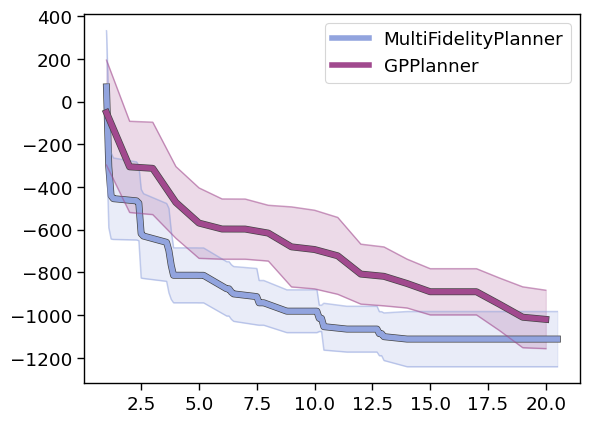

In [29]:
fig, ax = plt.subplots()
#for res in res_mf:
#    plot_min_trace_mean([res], unc=False,linewidth=1, color='#92a4de', shift=-0.637082925950332, ax=ax)
plot_min_trace_mean(res_mf, stde=True, color='#92a4de',  label='MultiFidelityPlanner', ax=ax)
plot_min_trace_mean(res_bo, stde=True, color='#a1498e',  label='GPPlanner', ax=ax)
ax.legend(loc='upper right')